<a href="https://colab.research.google.com/github/hmsch/porcelan/blob/main/figure_notebooks/figures_1_S1_S4_S13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from ete3 import Tree
import pickle
from torch import nn
import torch
import seaborn as sns
import umap
from sklearn.decomposition import PCA

%cd porcelan/
from plotting import double_tree_plot, kp_color_domain, nice_colors, interactive_plot, get_tsne, single_tree_plot, NAN_COLOR_VALUE
from scores import get_perm_dists, get_expected_lac_bmtm_depth_perm
from model import TreeGeneModel, AutoEncoder
from training import train, optimize_weights, train_triplet
from tree_util import get_node_and_edge_data, get_top_down_cluster_ids, augment_tree_with_weights, make_binary_tree
from perm_util import split_by_type, get_permutation_ids, extract_subsets_with_depth
from sim_util import generate_bmtm_data_from_tree, generate_noise_data_from_tree

data_path = './data'
results_path = './results'

/home/hschlueter/porcelan


# Load data and make cell type legend

# of cells: 1112
type                
AT2-like                667
Lung progenitor-like    214
AT1-like                114
High plasticity          67
Gastric-like             17
Pre-EMT                  15
Early EMT-1              11
Early EMT-2               3
Endoderm-like             3
Early gastric             1
dtype: int64


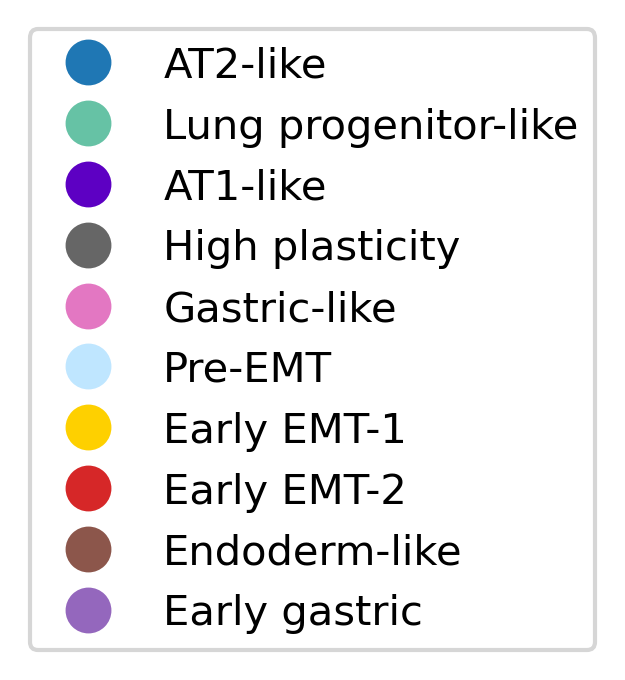

In [2]:
name = '3435_NT_T1'

tree_path = f'{data_path}/preprocessed/{name}_pruned.nwk'
lut_path = f'{data_path}/preprocessed/{name}_apn_pd_triplet_lut.npy'
with open(f'{data_path}/preprocessed/{name}_cells.txt') as f:
  labels_in_order = np.array(f.read().splitlines())

cell_types = pd.read_csv(f'{data_path}/preprocessed/{name}_cell_types.txt', header=None)
cell_types.columns = ['type']
cell_types.index = labels_in_order

color_df = pd.DataFrame(index=kp_color_domain)
color_df['color'] = nice_colors
color_df = color_df.loc[cell_types['type'].value_counts().index]

with open(f'{data_path}/preprocessed/{name}_hvg_genes.txt') as f:
  hvg_genes = np.array(f.read().splitlines())

expression = pd.read_csv(f'{data_path}/preprocessed/{name}_normalized_log_counts.txt')
expression.index = labels_in_order

cv = cell_types.value_counts()
main_types = ['All'] + [t[0] for t in cv.index[:4]]
cv = cell_types.value_counts()
print('# of cells:', len(cell_types))
print(cv)

legend_elements = []
for color, cell_type in zip(color_df['color'], color_df.index):
  legend_elements.append(Line2D([0], [0], marker='o', lw=0, color=color, label=cell_type, markersize=10))

fig, ax = plt.subplots(figsize=(2, 2), dpi=300)
ax.axis('off')
ax.legend(handles=legend_elements, loc='center', ncol=1)
fig.tight_layout()
fig.show()

# AE training

The cells below are for training different autoencoder architectures to reconstruct the expression of the 100 most highly variable genes, referred to as "pre-training" in the Methods Section.

To train the autoencoders for the different permutations of the data, run in a terminal:

```
python train_perm_tumor_aes.py -t '3435_NT_T1' -m '_hvg' -d 17 -c 'cuda:3' -k 'AELR-2-1000' -e 500 -s 100 250 500

python train_perm_tumor_aes.py -t '3435_NT_T1' -m '_hvg' -d 17 -c 'cuda:3' -k 'AELR-2-100' -e 500

python train_perm_tumor_aes.py -t '3435_NT_T1' -m '_hvg' -d 17 -c 'cuda:3' -k 'AELR-3-1000' -e 500
```

Training all of these models will take several hours in total.

epoch: 500; recon: 0.000448618258815; : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.53it/s]


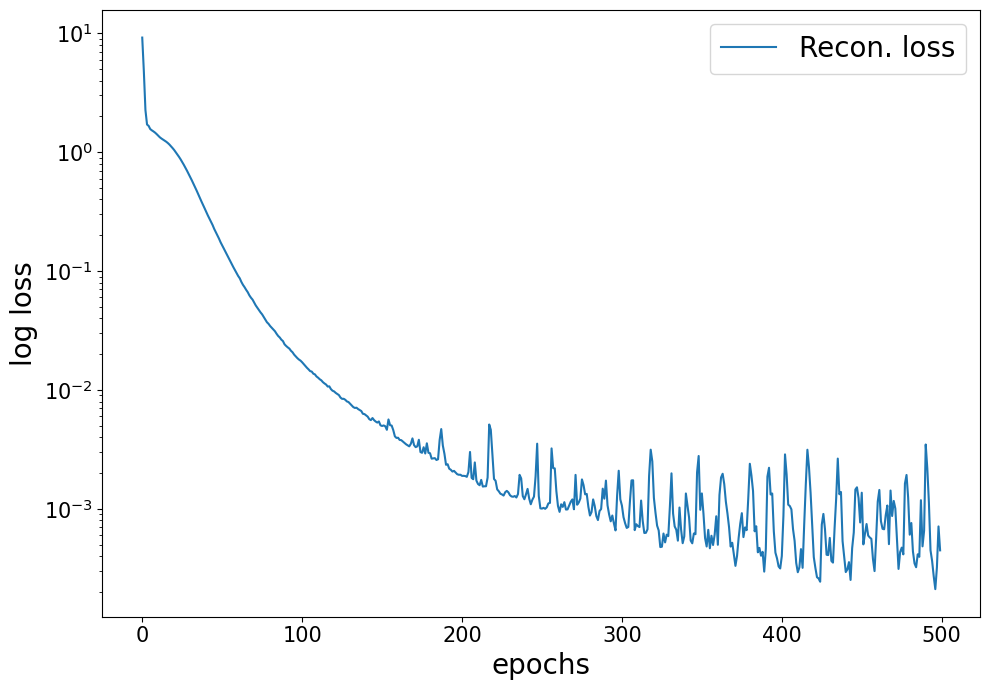

In [35]:
model = AutoEncoder(input_dim=len(hvg_genes), hidden_dim=1000, enc_layers=2, non_linearity=nn.LeakyReLU())
loss_plot = train(model, model_path=f'{results_path}/{name}_AELR-2-1000_lr1em4_e500_b128_hvg.pt',
                  gene_matrix=expression[hvg_genes].values, num_epochs=500, device='cuda:2',
                  n_genes=len(hvg_genes), batch_size=128, lr=1e-4, training_seed=88232)

epoch: 500; recon: 0.537360621823205; : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:41<00:00, 11.91it/s]


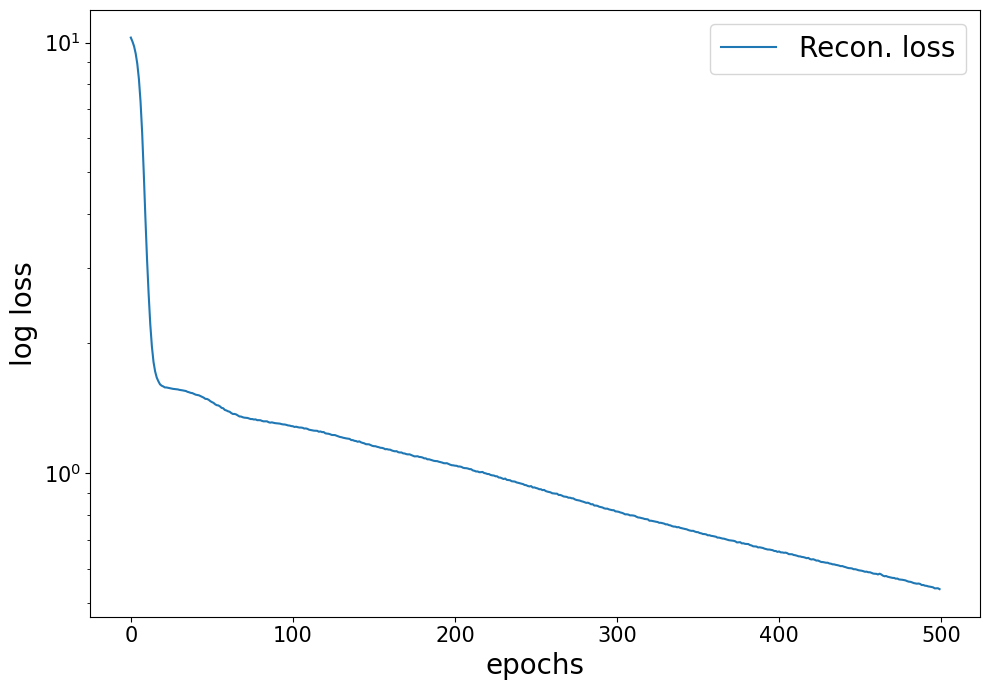

In [32]:
model = AutoEncoder(input_dim=len(hvg_genes), hidden_dim=100, enc_layers=2, non_linearity=nn.LeakyReLU())
loss_plot = train(model, model_path=f'{results_path}/{name}_AELR-2-100_lr1em4_e500_b128_hvg.pt',
                  gene_matrix=expression[hvg_genes].values, num_epochs=500, device='cuda:2',
                  n_genes=len(hvg_genes), batch_size=128, lr=1e-4, training_seed=88232)

epoch: 500; recon: 0.002759226830676; : 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.37it/s]


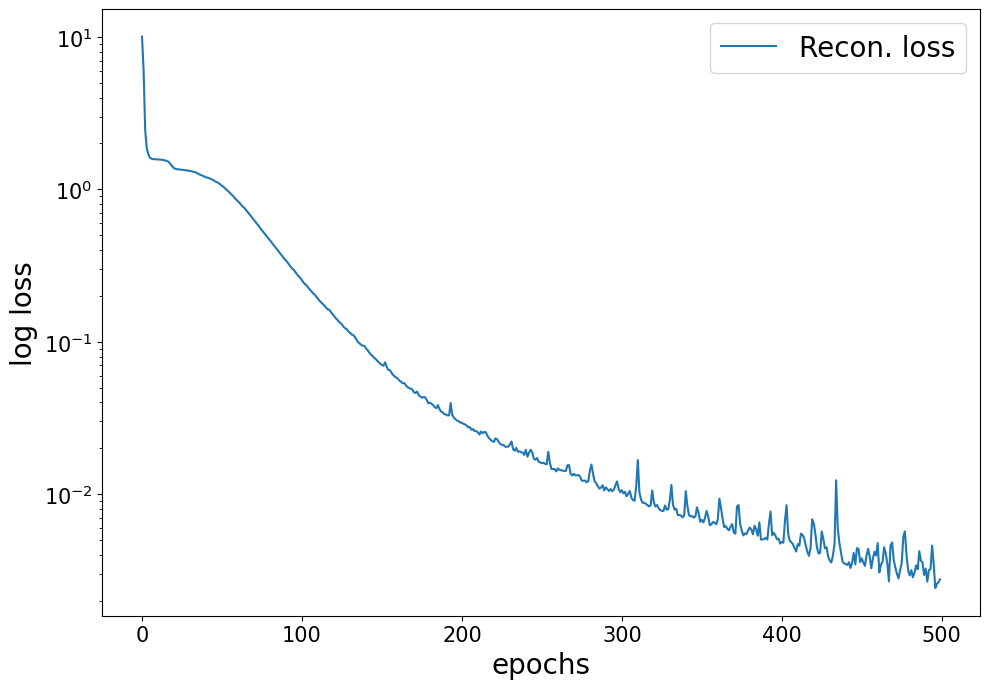

In [36]:
model = AutoEncoder(input_dim=len(hvg_genes), hidden_dim=1000, enc_layers=3, non_linearity=nn.LeakyReLU())
loss_plot = train(model, model_path=f'{results_path}/{name}_AELR-3-1000_lr1em4_e500_b128_hvg.pt',
                  gene_matrix=expression[hvg_genes].values, num_epochs=500, device='cuda:2',
                  n_genes=len(hvg_genes), batch_size=128, lr=1e-4, training_seed=88232)

loading model from path ./results/3435_NT_T1_AELR-2-1000_lr1em4_e500_b128_hvg.pt
done loading model from path
Pre-trained recon. loss is 0.0006934339762665331


epoch: 100; recon: 0.029202884063125; trip: 0.4433860480785; total: 0.472588926553726; :   5%|███▊                                                                       | 100/2000 [00:22<07:26,  4.26it/s]

Saved model at ./results/3435_NT_T1_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e100.pt


epoch: 250; recon: 0.023909322917461; trip: 0.1478286534548; total: 0.171737968921661; :  12%|█████████▍                                                                 | 250/2000 [00:57<06:54,  4.22it/s]

Saved model at ./results/3435_NT_T1_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e250.pt


epoch: 500; recon: 0.012471523135900; trip: 0.0348257720470; total: 0.047297295182943; :  25%|██████████████████▊                                                        | 500/2000 [01:55<06:02,  4.14it/s]

Saved model at ./results/3435_NT_T1_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e500.pt


epoch: 2000; recon: 0.001495246426202; trip: 0.0004614268546; total: 0.001956673339009; : 100%|█████████████████████████████████████████████████████████████████████████| 2000/2000 [07:42<00:00,  4.32it/s]


Saved model at ./results/3435_NT_T1_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e2000.pt
Evaluating model ...
Total rec loss: 0.0017196773551404476
Total trip loss: 0.0005035350332036614


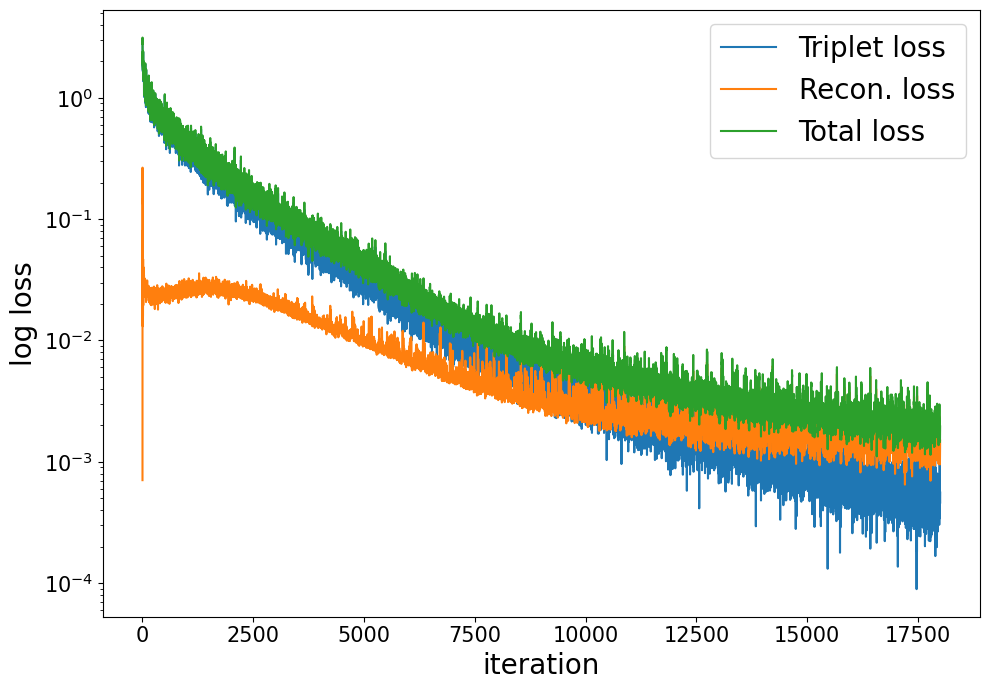

In [7]:
# train AE for 2000 epochs with triplet loss
_ = train_triplet(model=None, model_path=f'{results_path}/{name}_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg.pt',
                  training_seed=12345, n_genes=len(hvg_genes), h=1, gene_matrix=expression[hvg_genes].values,
                  apn_lut_path=lut_path, display=True, num_epochs=2000, device='cuda:0', batch_size=128,
                  lr=1e-4, init_path=f'{results_path}/{name}_AELR-2-1000_lr1em4_e500_b128_hvg.pt',
                  save_epochs=[100, 250, 500, 2000])

# Figure 1

## Trees and t-SNE

In [3]:
def get_features(model, genes, device):
  model.to(device).eval()
  with torch.no_grad():
    _, x_z = model.forward(torch.from_numpy(genes).float().to(device), return_z=True)
  return x_z.cpu().numpy()

In [5]:
np.random.seed(123121)
gene_tsne = get_tsne(expression[hvg_genes].values)
learnt_tsne = get_tsne(get_features(
    torch.load(f'{results_path}/{name}_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e2000.pt',
               map_location=torch.device('cuda:0')),
    expression[hvg_genes].values, 'cuda:0'))

_, top_down_clusters = get_top_down_cluster_ids(tree_path, labels_in_order, depth=1)
node_data, edge_data = get_node_and_edge_data(tree_path)
interactive_plot(node_data, edge_data, labels_in_order,
                 [cell_types.loc[labels_in_order]['type'].values.tolist(), top_down_clusters],
                 ['cell types', 'top_down_clusters'],
                 [gene_tsne, learnt_tsne],
                 ['TSNE of preprocessed gene expression', 'TSNE of learnt features gene expression']
                 ).configure_legend(orient='bottom', direction='horizontal')

/home/hschlueter/anaconda3/envs/myenv-38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hschlueter/anaconda3/envs/myenv-38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/hschlueter/anaconda3/envs/myenv-38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/hschlueter/anaconda3/envs/myenv-38/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


alt.HConcatChart(...)

## Example gene and edge weight optimization

epoch: 1000; score: 4.106586239698252; : 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:10<00:00, 99.22it/s]


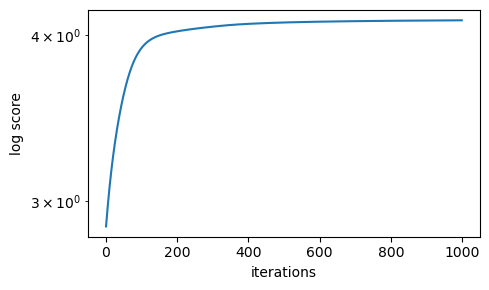

In [43]:
# simulate half tree BMTM and half tree random noise
small_tree_path = f'{data_path}/preprocessed/d5tree.nwk'
d5tree = Tree(make_binary_tree(depth=5), format=1)
d5tree.write(outfile=small_tree_path, format=1)
d5left, d5right = d5tree.get_children()
d5bmtm20 = generate_bmtm_data_from_tree(d5left, dim=20, sigma=1)
d5less20 = pd.concat([d5bmtm20, generate_noise_data_from_tree(d5right, dim=20, sigma=1,  seed=234856)])
small_norm_expression = ((d5less20 - d5less20.mean(axis=0))/d5less20.std(axis=0))

# optimize gene and edge weights
model = TreeGeneModel(small_tree_path, small_norm_expression.index,
                      skip_tip_distance=-1, gene_dim=len(small_norm_expression.columns))
loss_fig = optimize_weights(model, small_norm_expression.values, lr=1e-2, epochs=1000)
ew_df = pd.DataFrame(torch.exp(model.log_edge_weights.detach()).cpu().numpy(), index=model.edges_ends, columns=['weight'])
loss_fig.show()

In [46]:
# plot unoptimized tree
etree = augment_tree_with_weights(small_tree_path, 1 + 0 * ew_df['weight'])
etree.write(outfile=f'{data_path}/temp.nwk', format=1)
node_data, edge_data = get_node_and_edge_data(f'{data_path}/temp.nwk')
node_data.loc[0, 'cell_label'] = 'N0000'

inner_names = list(set(ew_df.index) - set(small_norm_expression.index))
node_labels = np.concatenate([small_norm_expression.index.values, inner_names])
single_tree_plot(node_data, edge_data, cell_labels=node_labels.tolist(),
          colors=[np.concatenate([small_norm_expression[c], NAN_COLOR_VALUE * np.ones(len(inner_names))]) for c in small_norm_expression.columns],
          color_names=small_norm_expression.columns.values.tolist(), nan_smaller=True,
          tooltip_names=['cell_label'], show_legend=True, continuous_colors=True, node_size=60, width=300)

alt.LayerChart(...)

In [47]:
# plot resulting tree
etree = augment_tree_with_weights(small_tree_path, ew_df['weight'])
etree.write(outfile=f'{data_path}/temp.nwk', format=1)
node_data, edge_data = get_node_and_edge_data(f'{data_path}/temp.nwk')
node_data.loc[0, 'cell_label'] = 'N0000'

inner_names = list(set(ew_df.index) - set(small_norm_expression.index))
node_labels = np.concatenate([small_norm_expression.index.values, inner_names])
single_tree_plot(node_data, edge_data, cell_labels=node_labels.tolist(),
          colors=[np.concatenate([small_norm_expression[c], NAN_COLOR_VALUE * np.ones(len(inner_names))]) for c in small_norm_expression.columns] + [ew_df.loc[node_labels, 'weight']],
          color_names=small_norm_expression.columns.values.tolist() + ['incoming edge weight'], nan_smaller=True,
          tooltip_names=['cell_label'], show_legend=True, continuous_colors=True, node_size=60, width=300)

alt.LayerChart(...)

# Figure S1

Reuses t-SNE computed for Fig. 1.

## Visualize data and representations

In [4]:
_, top_down_clusters = get_top_down_cluster_ids(tree_path, labels_in_order, depth=1)

color_df2 = pd.DataFrame(index=kp_color_domain)
color_df2['color'] = nice_colors
color_df2 = color_df2.loc[np.unique(top_down_clusters)]

cell_types_array = cell_types.loc[labels_in_order]['type'].values
features = get_features(torch.load(f'{results_path}/{name}_AELR-2-1000_lr1em4_e2000_b128_h1_pd_pre_ts12345_hvg_e2000.pt',
               map_location=torch.device('cuda:0')),
                        expression[hvg_genes].values, 'cuda:0')

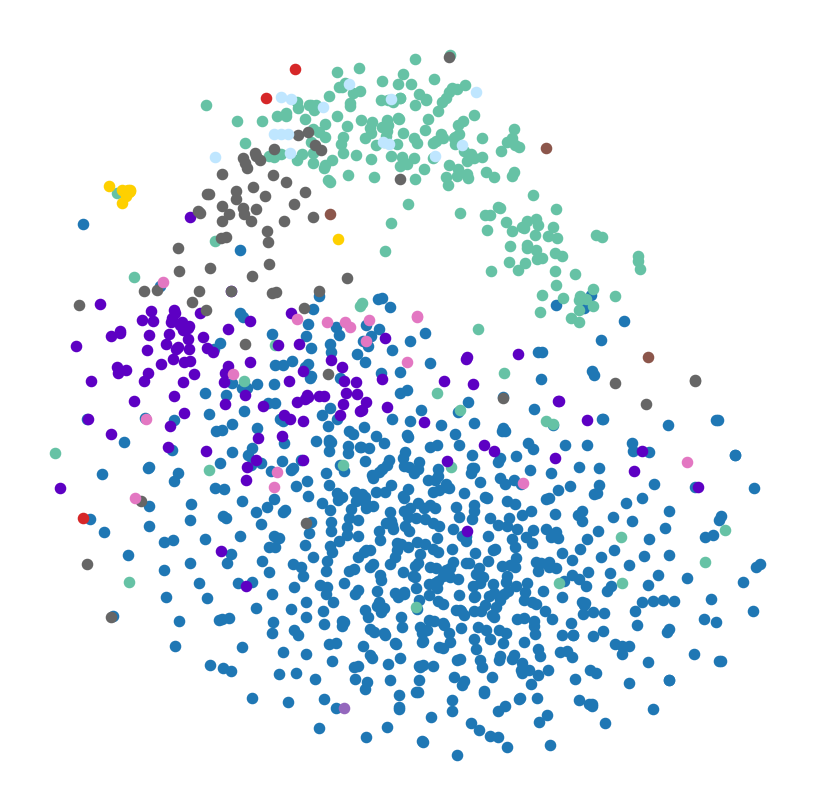

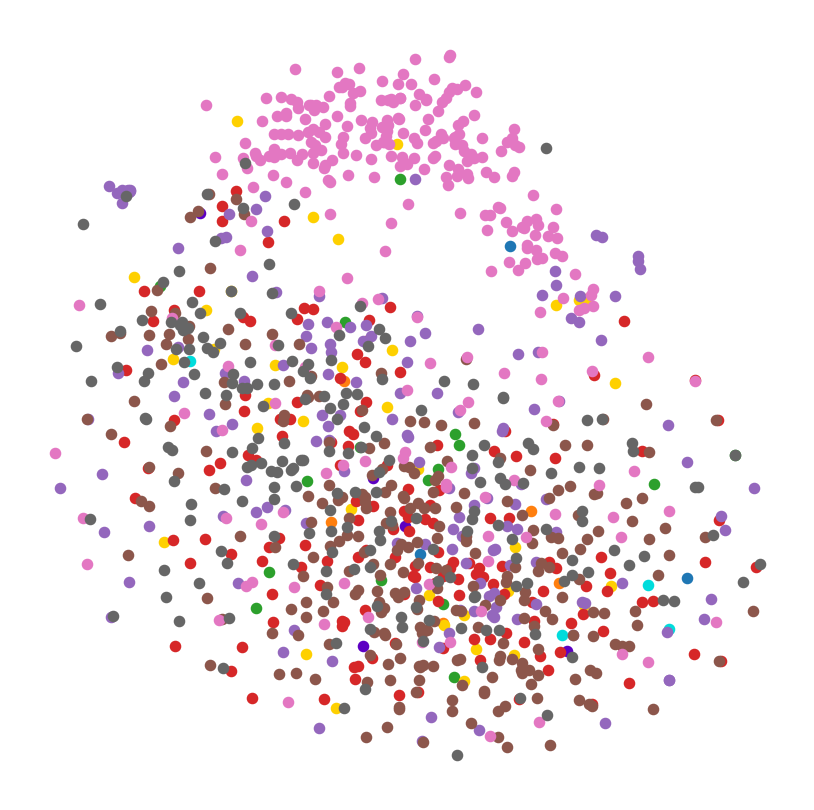

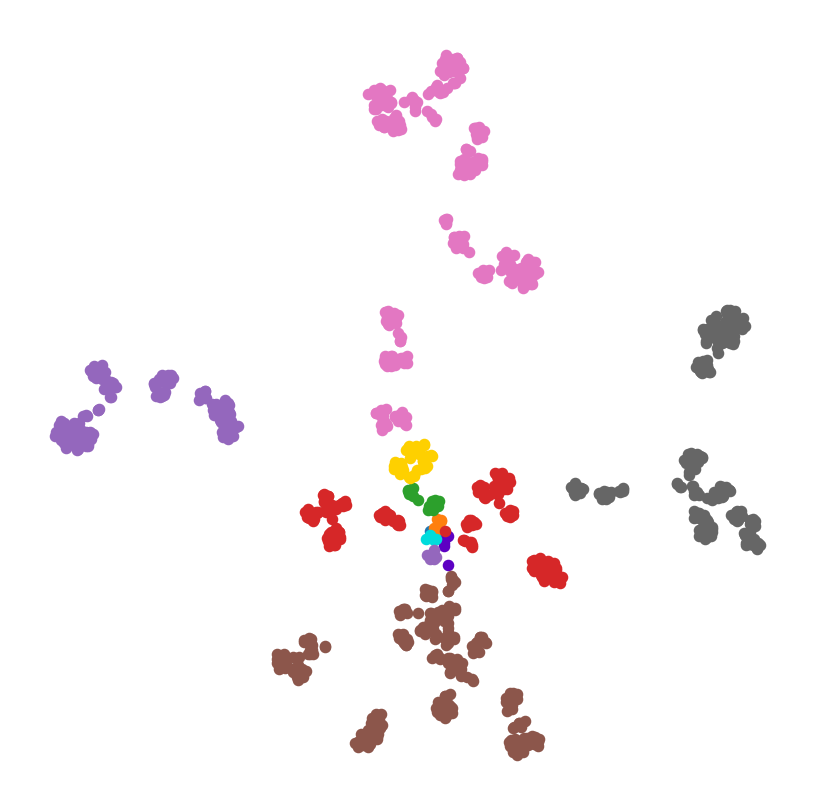

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df.itertuples():
  ax.scatter(x=gene_tsne[cell_types_array == t, 0], y=gene_tsne[cell_types_array == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=gene_tsne[top_down_clusters == t, 0], y=gene_tsne[top_down_clusters == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=learnt_tsne[top_down_clusters == t, 0], y=learnt_tsne[top_down_clusters == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

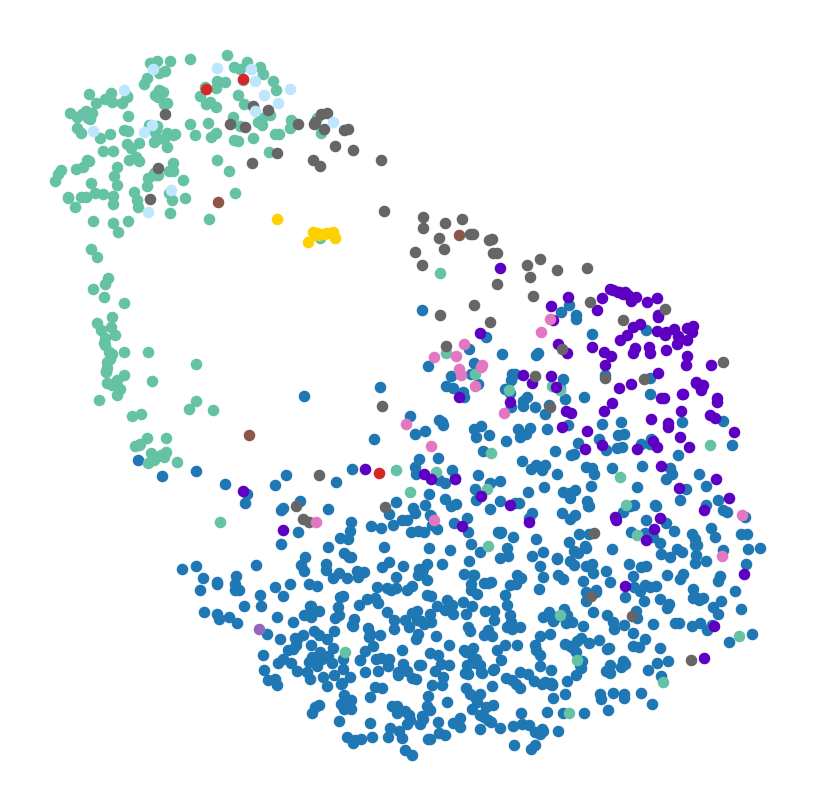

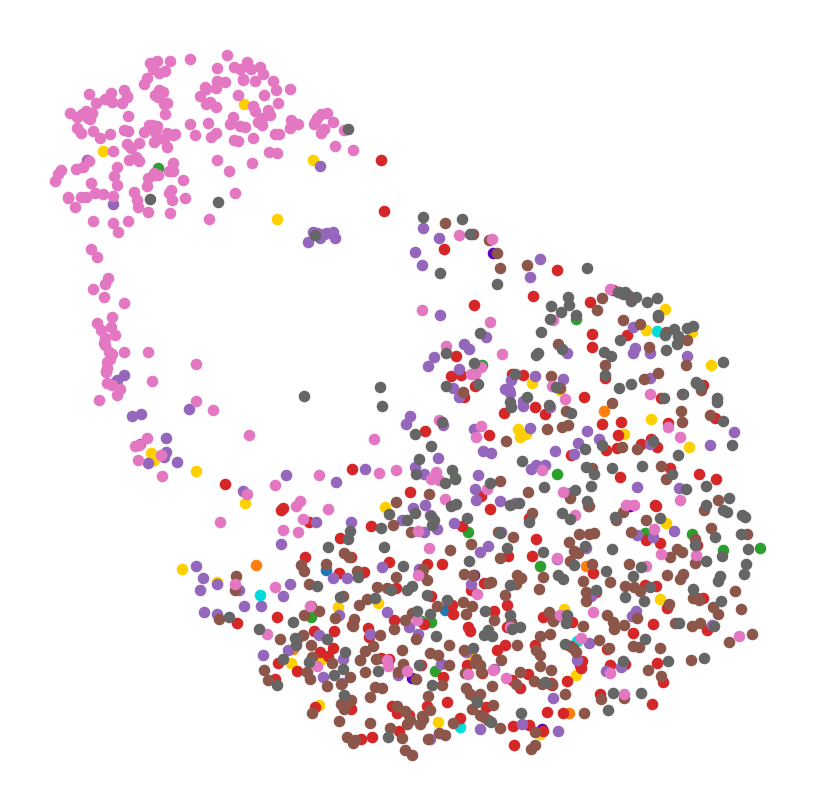

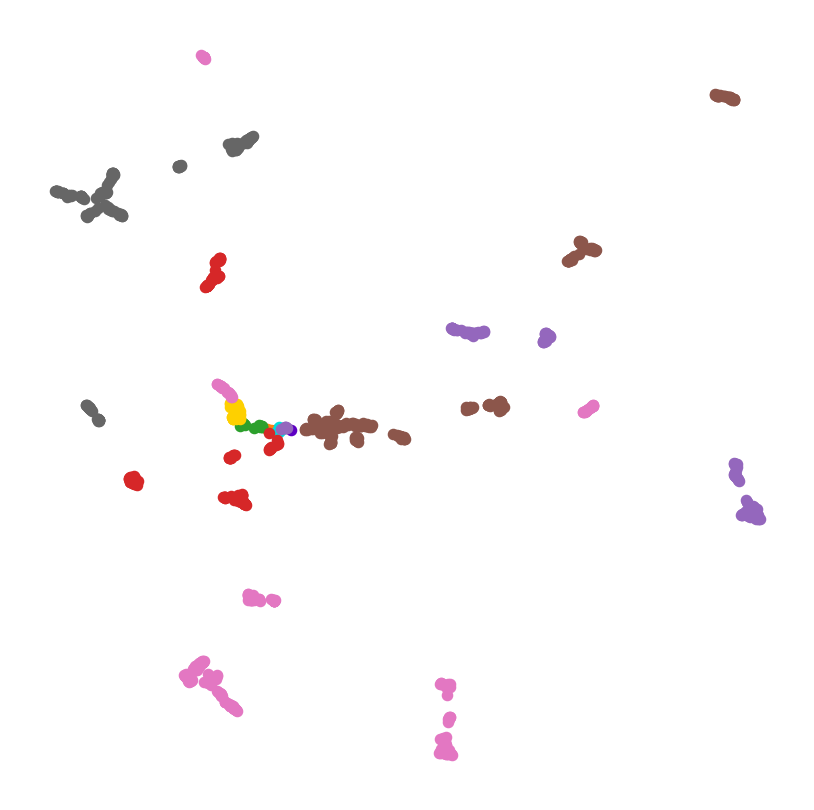

In [52]:
def get_umap(features):
  return umap.UMAP().fit_transform(features)

np.random.seed(123121)
gene_umap = get_umap(expression[hvg_genes].values)
learnt_umap = get_umap(features)

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df.itertuples():
  ax.scatter(x=gene_umap[cell_types_array == t, 0], y=gene_umap[cell_types_array == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=gene_umap[top_down_clusters == t, 0], y=gene_umap[top_down_clusters == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=learnt_umap[top_down_clusters == t, 0], y=learnt_umap[top_down_clusters == t, 1], color=c, s=10)
ax.axis('off')
fig.show()

In [ ]:
def get_pca2(features):
  return PCA(n_components=2).fit_transform(features)

np.random.seed(123121)
gene_pca = get_pca2(expression[hvg_genes].values)
learnt_pca = get_pca2(features)

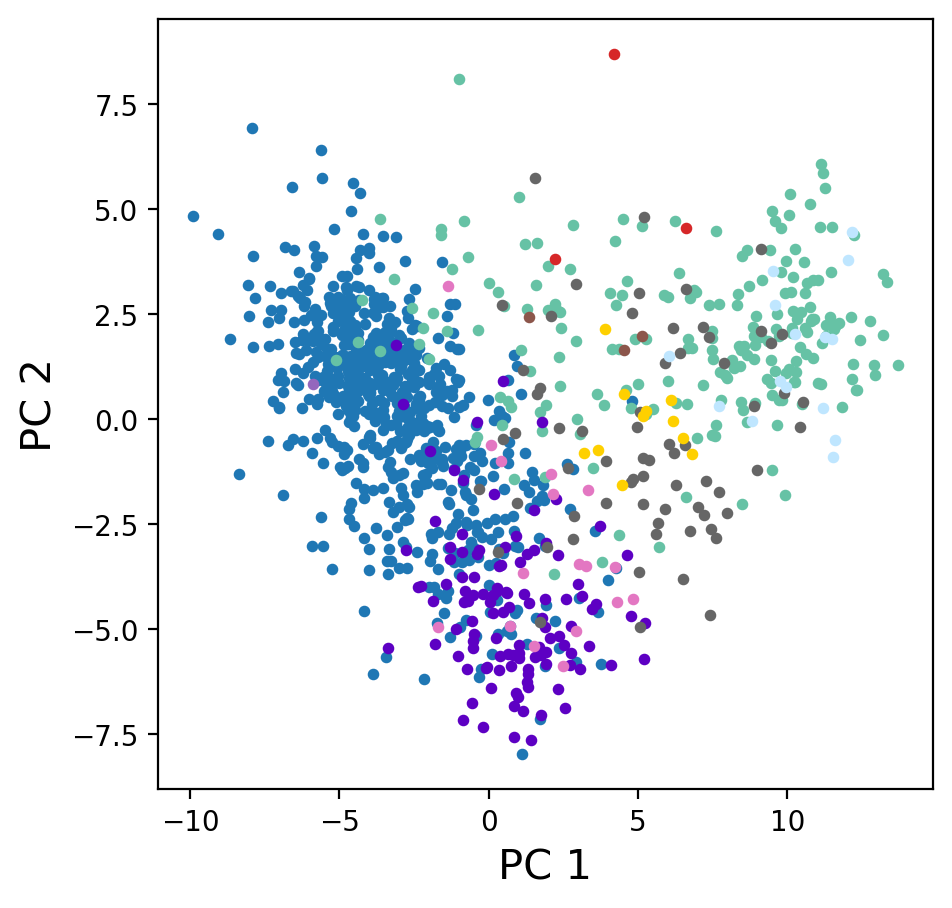

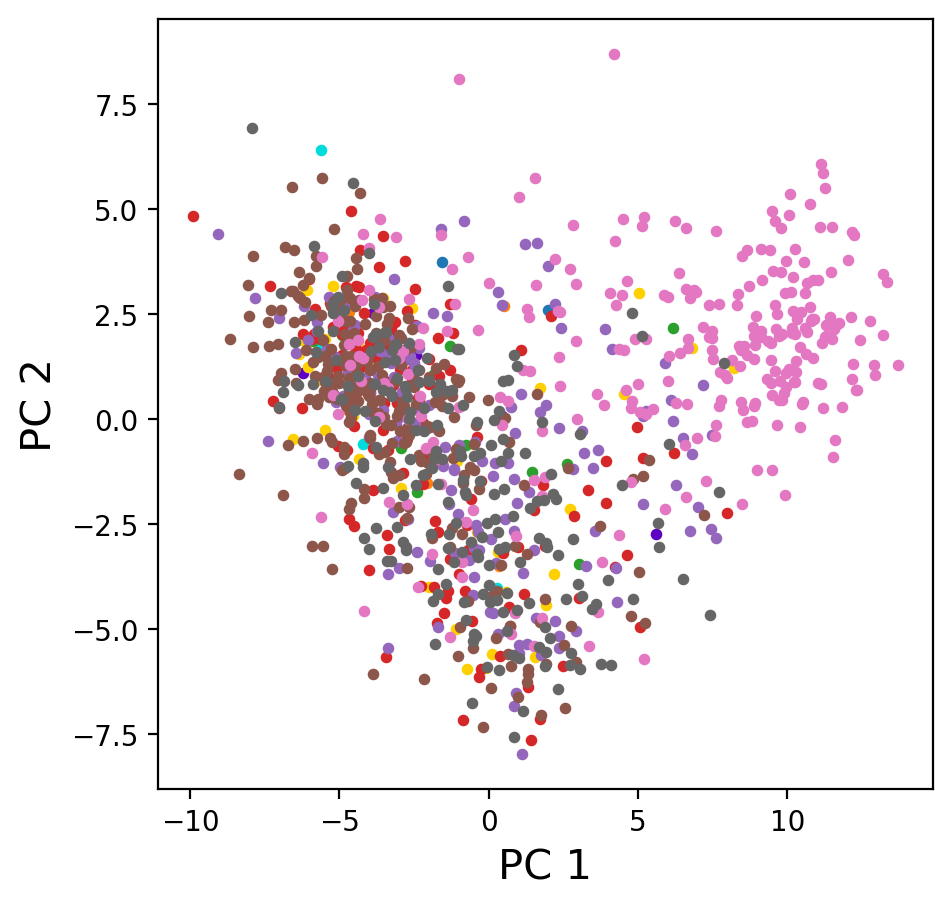

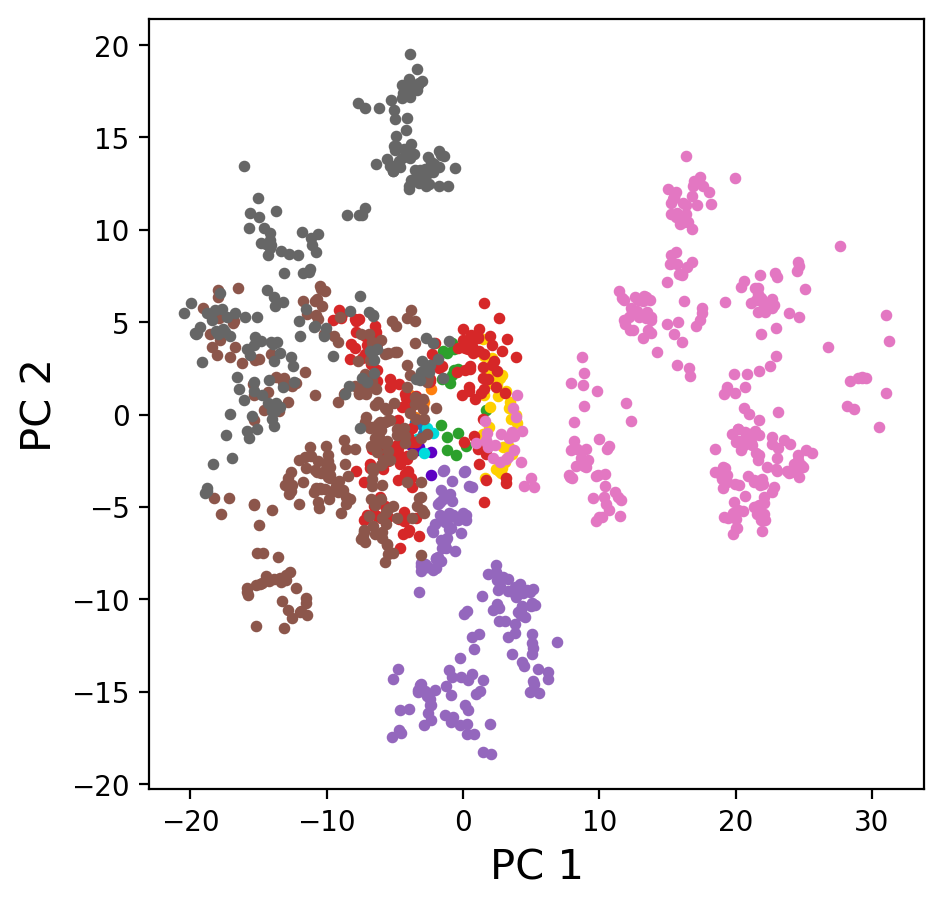

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df.itertuples():
  ax.scatter(x=gene_pca[cell_types_array == t, 0], y=gene_pca[cell_types_array == t, 1], color=c, s=10)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=gene_pca[top_down_clusters == t, 0], y=gene_pca[top_down_clusters == t, 1], color=c, s=10)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=learnt_pca[top_down_clusters == t, 0], y=learnt_pca[top_down_clusters == t, 1], color=c, s=10)
ax.set_xlabel('PC 1', fontsize=15)
ax.set_ylabel('PC 2', fontsize=15)
fig.show()

In [9]:
%cd ../tree-climbing/
# local copy of https://github.com/facebookresearch/PoincareMaps
from PoincareMaps.main import compute_poincare_maps
%cd ../porcelan/

def get_poincare(features, labels):
  features = torch.from_numpy(features)
  poincare_coord, _ = compute_poincare_maps(
      features, labels, 'example', mode='features', k_neighbours=15,
      distlocal='minkowski', sigma=1.0, gamma=2.0, color_dict=None, epochs=500,
      batchsize=-1, lr=0.1, earlystop=0.0001, cuda=0)
  return poincare_coord

np.random.seed(123121)
gene_poincare = get_poincare(expression[hvg_genes].values, labels_in_order)
pd.DataFrame(gene_poincare).to_csv(f'{results_path}/{name}_hvg_poincare.csv', header=False, index=False)
learnt_poincare = get_poincare(features, labels_in_order)
pd.DataFrame(learnt_poincare).to_csv(f'{results_path}/{name}_ae_poincare.csv', header=False, index=False)

/home/hschlueter/tree-climbing
/home/hschlueter/porcelan
Computing laplacian...
Laplacian computed in 0.11 sec
Computing RFA...
RFA computed in 4.55 sec
batchsize =  111
Starting training...


loss: 0.27003: 100%|██████████████████████████| 500/500 [54:33<00:00,  6.55s/it]


PM computed in 3273.72 sec
loss = 2.700e-01
time = 54.565 min
Computing laplacian...
Laplacian computed in 0.32 sec
Computing RFA...
RFA computed in 4.25 sec
batchsize =  111
Starting training...


loss: 0.32704: 100%|██████████████████████████| 500/500 [49:13<00:00,  5.91s/it]


PM computed in 2953.39 sec
loss = 3.270e-01
time = 49.226 min


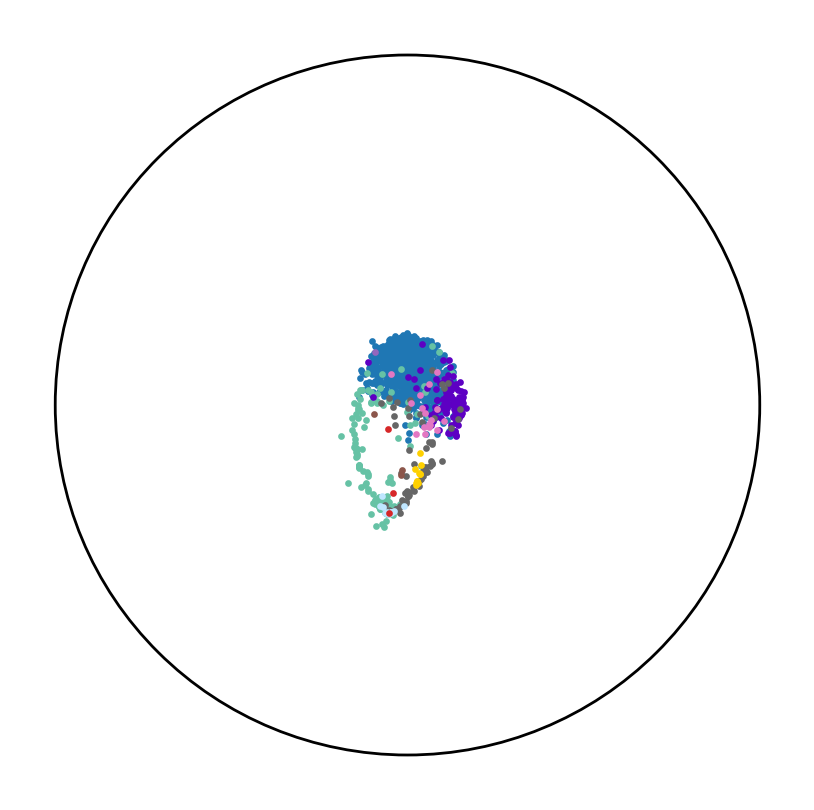

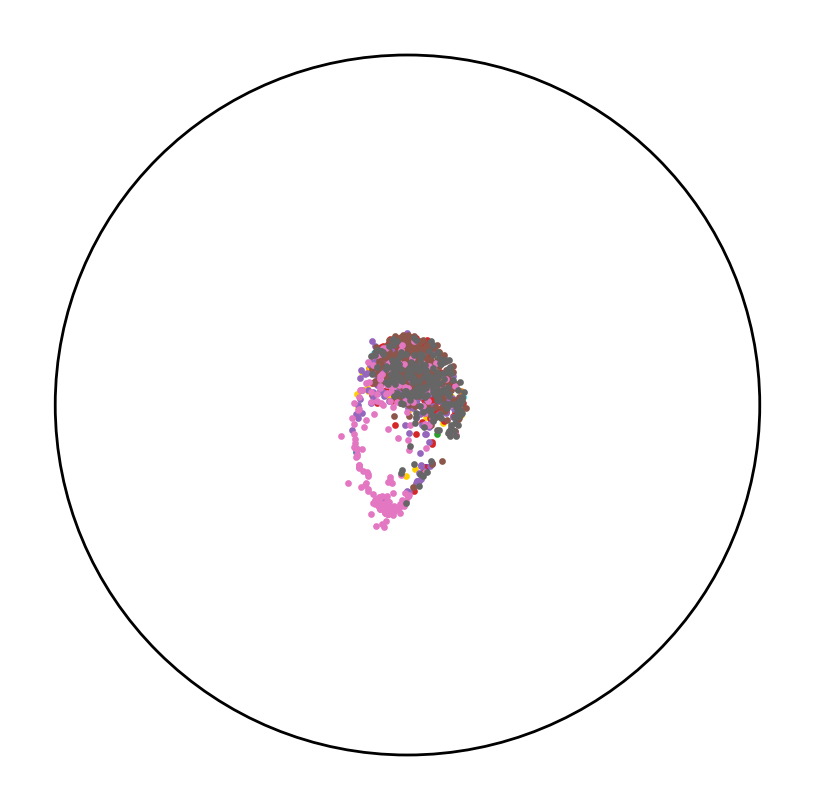

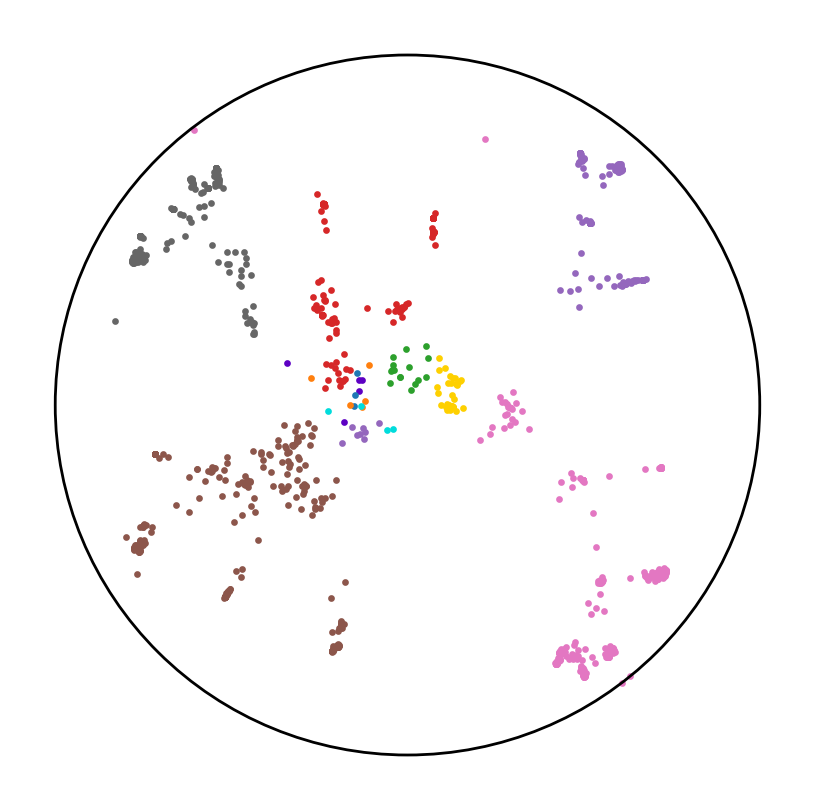

In [5]:
gene_poincare = pd.read_csv(f'{results_path}/{name}_hvg_poincare.csv', header=None).values
learnt_poincare = pd.read_csv(f'{results_path}/{name}_ae_poincare.csv', header=None).values

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df.itertuples():
  ax.scatter(x=gene_poincare[cell_types_array == t, 0], y=gene_poincare[cell_types_array == t, 1], color=c, s=2)

circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_patch(circle)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=gene_poincare[top_down_clusters == t, 0], y=gene_poincare[top_down_clusters == t, 1], color=c, s=2)

circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_patch(circle)
ax.axis('off')
fig.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=200)
for t, c in color_df2.itertuples():
  ax.scatter(x=learnt_poincare[top_down_clusters == t, 0], y=learnt_poincare[top_down_clusters == t, 1], color=c, s=2)

circle = plt.Circle((0, 0), 1, color='k', fill=False)
ax.add_patch(circle)
ax.axis('off')
fig.show()

## Histograms of HVG counts

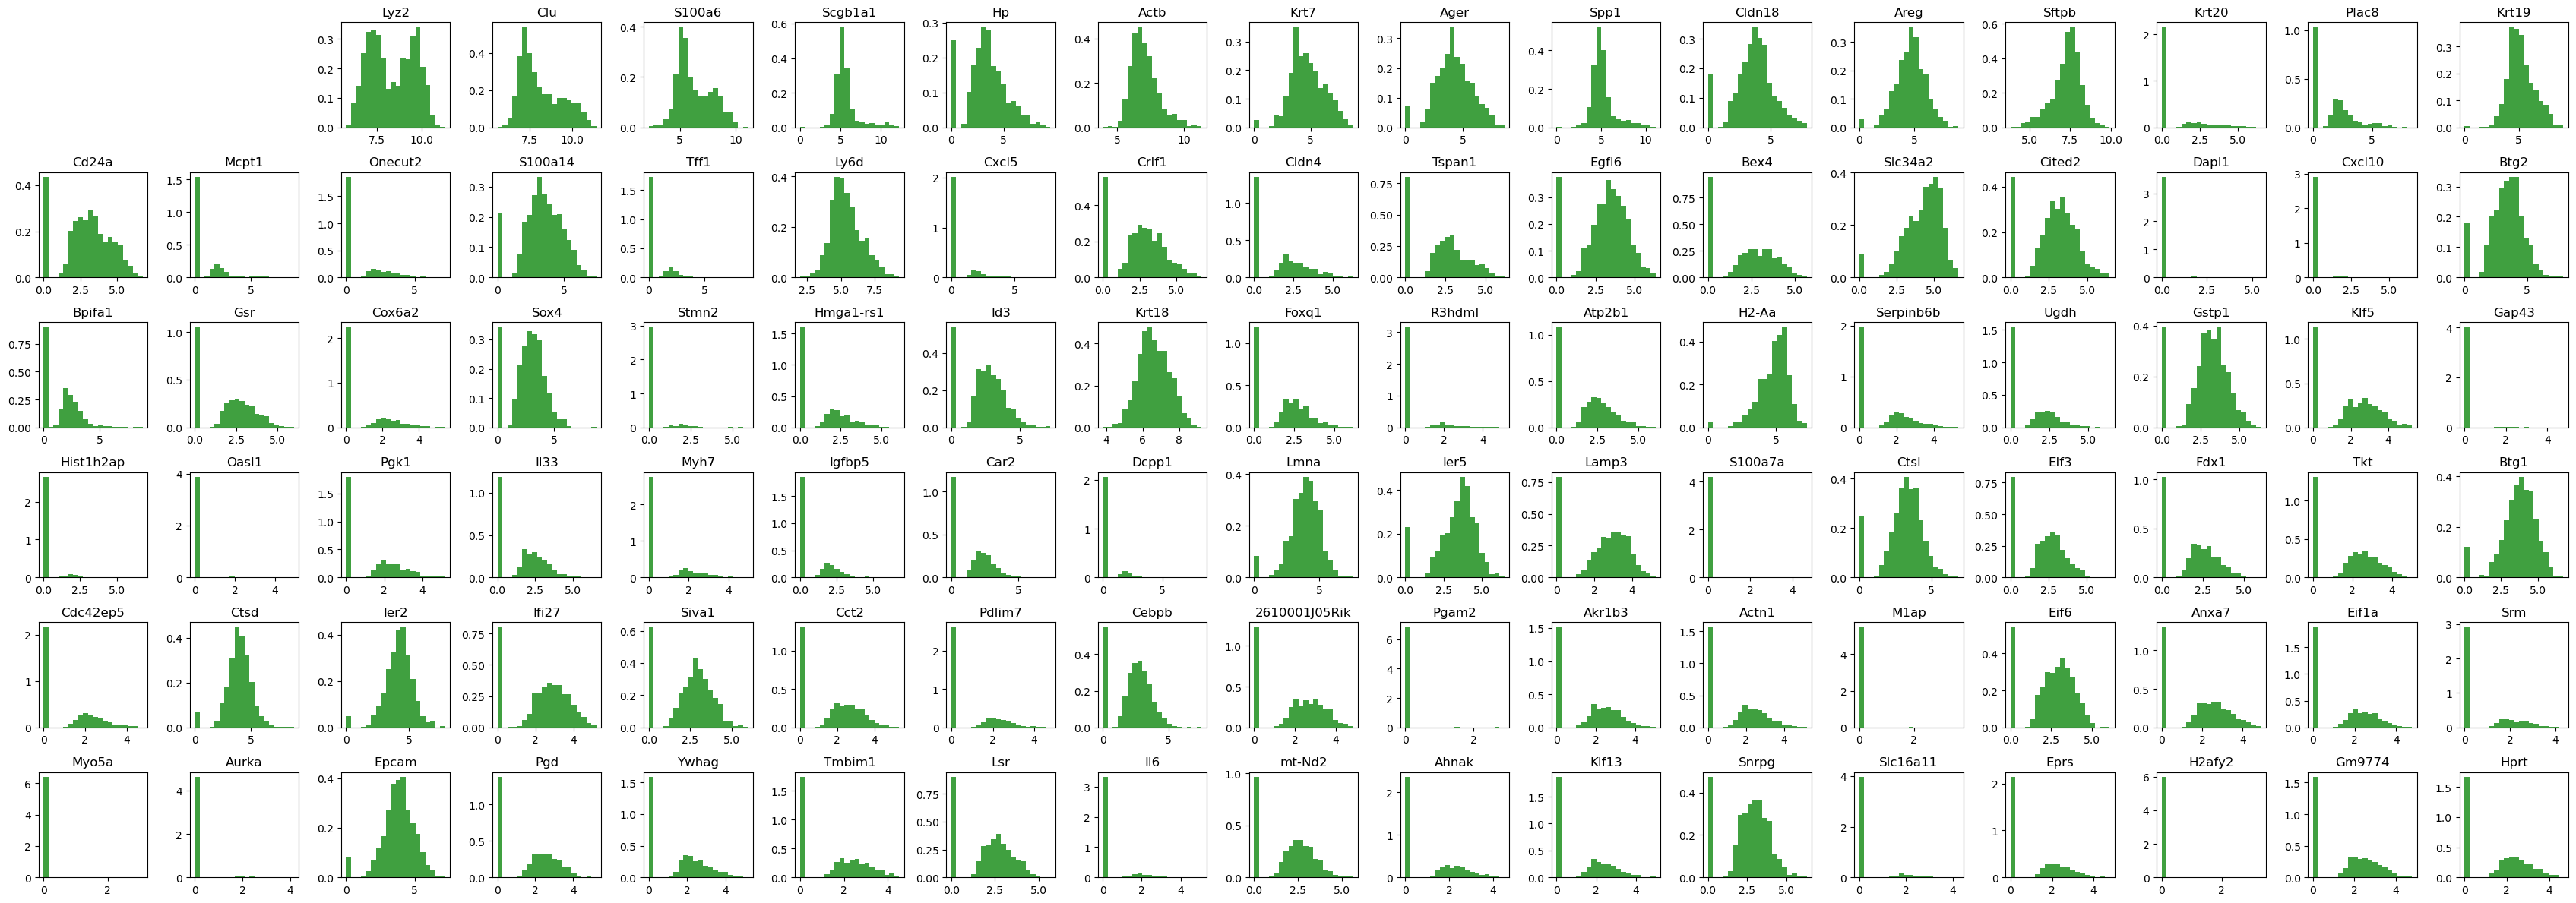

In [9]:
fig, axs = plt.subplots(6, 17, figsize=(34, 12))
for i, ax in enumerate(axs.flatten()[2:]):
  ax.hist(expression[hvg_genes[i]].values, 20, density=True, facecolor='g', alpha=0.75)
  ax.set_title(hvg_genes[i])
axs[0,0].axis('off')
axs[0,1].axis('off')
fig.tight_layout()
fig.show()

# Figure S4

## AE results

In [4]:
def aggregate_losses(name, n_genes, max_depth, gene_subset_name,
                     max_epoch=100, stops=[1, 3, 8, 15, 30, 50, 100],
                     training_seeds=[112221, 99483, 92231, 6243321, 555242],
                     perm_seeds=[12345, 66689, 41382, 3838374, 12311],
                     types_fixed=True, model_kind='AELR-2-1000'):
  df = pd.DataFrame()
  batches_per_epoch = 0
  type_str = 'type' if types_fixed else ''
  for training_seed in training_seeds:
    for perm_seed in perm_seeds:
      # without permutation (d=0) only need one model per training seed
      for d in range(0 if perm_seed == perm_seeds[0] else 1, max_depth+1):
        loss_path = f'{results_path}/{name}_{model_kind}_lr1em4_e{max_epoch}_b128_h1_pd_pre_ts{training_seed}_perm{perm_seed}d{d}{type_str}_g{n_genes}{gene_subset_name}_loss.csv'
        try:
          dfi = pd.read_csv(loss_path)
        except FileNotFoundError as e:
          print(e)
          continue
        except EmptyDataError as e:
          print(e)
          continue
        dfi['training_seed'] = training_seed
        dfi['perm_seed'] = perm_seed
        dfi['depth'] = d
        dfi = dfi.rename(columns={'recon_loss': 'rec_loss'})
        df = pd.concat([df, dfi])
        batches_per_epoch = len(dfi) // max_epoch  # same for all

  if len(df) == 0:
    return None, None

  df['epoch'] = df['iter'] // batches_per_epoch + 1

  df_stops = pd.DataFrame()
  for stop in stops:
    df_epoch = df[df['epoch'] == stop].groupby(['training_seed', 'perm_seed', 'depth'])[['trip_loss', 'rec_loss']].mean().reset_index()
    df_epoch['stop'] = stop
    df_stops = pd.concat([df_stops, df_epoch])

  # add epoch 0 copied from iter 0
  epoch_agg = df.groupby(['depth', 'epoch', 'training_seed', 'perm_seed']).mean().reset_index()
  iter0_agg = df[df['iter'] == 0].groupby(['depth', 'epoch', 'training_seed', 'perm_seed']).mean().reset_index()
  iter0_agg['epoch'] = 0
  epoch_agg = pd.concat((iter0_agg, epoch_agg))
  epoch_agg = epoch_agg.groupby(['depth', 'epoch']).agg(
    rec_mean=pd.NamedAgg(column="rec_loss", aggfunc="mean"),
    rec_min=pd.NamedAgg(column="rec_loss", aggfunc="min"),
    rec_max=pd.NamedAgg(column="rec_loss", aggfunc="max"),
    trip_mean=pd.NamedAgg(column="trip_loss", aggfunc="mean"),
    trip_min=pd.NamedAgg(column="trip_loss", aggfunc="min"),
    trip_max=pd.NamedAgg(column="trip_loss", aggfunc="max"))
  epoch_agg = epoch_agg.reset_index()
  return epoch_agg, df_stops


def loss_perm_plots(name, model_kind, max_depth, stops, max_epoch, n_genes=100, gene_subset_name='_hvg'):
  epoch_df, stop_df = aggregate_losses(name, n_genes, max_depth, gene_subset_name, max_epoch=max_epoch,
                                     stops=stops, model_kind=model_kind)
  fig, axs = plt.subplots(1, 2, figsize=(8, 2.7), dpi=300)

  num_colors = len(epoch_df['depth'].unique())
  assert num_colors <= 20
  cm1 = plt.get_cmap('tab10')
  cm2 = sns.color_palette('pastel', as_cmap=True)
  colors =  [cm2[i] for i in range(num_colors - 10 - 1)] + [cm1(9 - i) for i in range(10)]
  axs[0].set_prop_cycle(color=colors)
  axs[1].set_prop_cycle(color=colors)

  for d in range(1, max_depth+1, 1):
    aggd = epoch_df[(epoch_df['depth'] == d)]
    axs[1].plot(aggd['epoch'], aggd['trip_mean'], label=f'{d}', lw=1)
    axs[0].plot(aggd['epoch'], aggd['rec_mean'], label=f'{d}', lw=1)

  for ax in axs[:1]:
    ax.legend(prop={'size':8}, ncol=4, title='subtree depth for permutation')
  for ax in axs[1:]:
    for stop in stops:
      ax.axvline(stop, color='black', linestyle=':', lw=1)
  for ax in axs:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', labelsize=8)
    ax.set_xlabel('epoch', fontsize=11)

  axs[1].set_ylabel('triplet loss', fontsize=11)
  axs[0].set_ylabel('reconstruction loss', fontsize=11)
  fig.tight_layout()


  fig, axs = plt.subplots(1, 3, figsize=(8, 4), dpi=300)

  num_colors = len(epoch_df['depth'].unique())
  assert num_colors <= 20
  cm1 = plt.get_cmap('tab10')
  cm2 = sns.color_palette('pastel', as_cmap=True)
  colors =  [cm2[i] for i in range(num_colors - 10 - 1)] + [cm1(9 - i) for i in range(10)]
  for ax in axs:
    ax.set_prop_cycle(color=colors)

  ranges = [(0, 30), (50, 100), (450, 500)]
  for ax, ran in zip(axs, ranges):
    for d in range(1, max_depth+1, 1):
      aggd = epoch_df[(epoch_df['depth'] == d) & (epoch_df['epoch'] >= ran[0]) & (epoch_df['epoch'] <= ran[1])]
      ax.plot(aggd['epoch'], aggd['trip_mean'], label=f'{d}')

  for ax in axs:
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', labelsize=8)
    ax.set_xlabel('epoch', fontsize=11)
    ax.set_ylabel('triplet loss', fontsize=11)
  fig.tight_layout()


  fig, axs = plt.subplots(2, 3, figsize=(15, 8))

  for stop, ax2 in zip(stops, axs.flatten()):
    agg = stop_df[stop_df['stop'] == stop].groupby('depth').agg(
      trip_mean=pd.NamedAgg(column="trip_loss", aggfunc="mean"),
      trip_std=pd.NamedAgg(column="trip_loss", aggfunc="std"),
      trip_med=pd.NamedAgg(column="trip_loss", aggfunc="median"),
      trip_min=pd.NamedAgg(column="trip_loss", aggfunc="min"),
      trip_max=pd.NamedAgg(column="trip_loss", aggfunc="max"))

    ax2.errorbar(agg.index, -agg['trip_mean'], yerr=agg['trip_std'], label='neg. triplet loss \nmean +/- std', color='red', fmt='--', capsize=5)
    ax2.legend(prop={'size': 16})
    ax2.set_xlabel('subtree depth for permutation', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title(f'Tree-likeness scores at epoch {stop}', fontsize=18)

    a, b = (-agg['trip_mean'] - agg['trip_std']).min(), (-agg['trip_mean'] + agg['trip_std']).max()
    ax2.set_ylim(a - 0.05 * (b - a), b + 0.05 * (b - a))
    ax2.set_xticks(agg.index.values[::4].tolist())

  fig.tight_layout()
  fig.subplots_adjust(hspace=0.4)

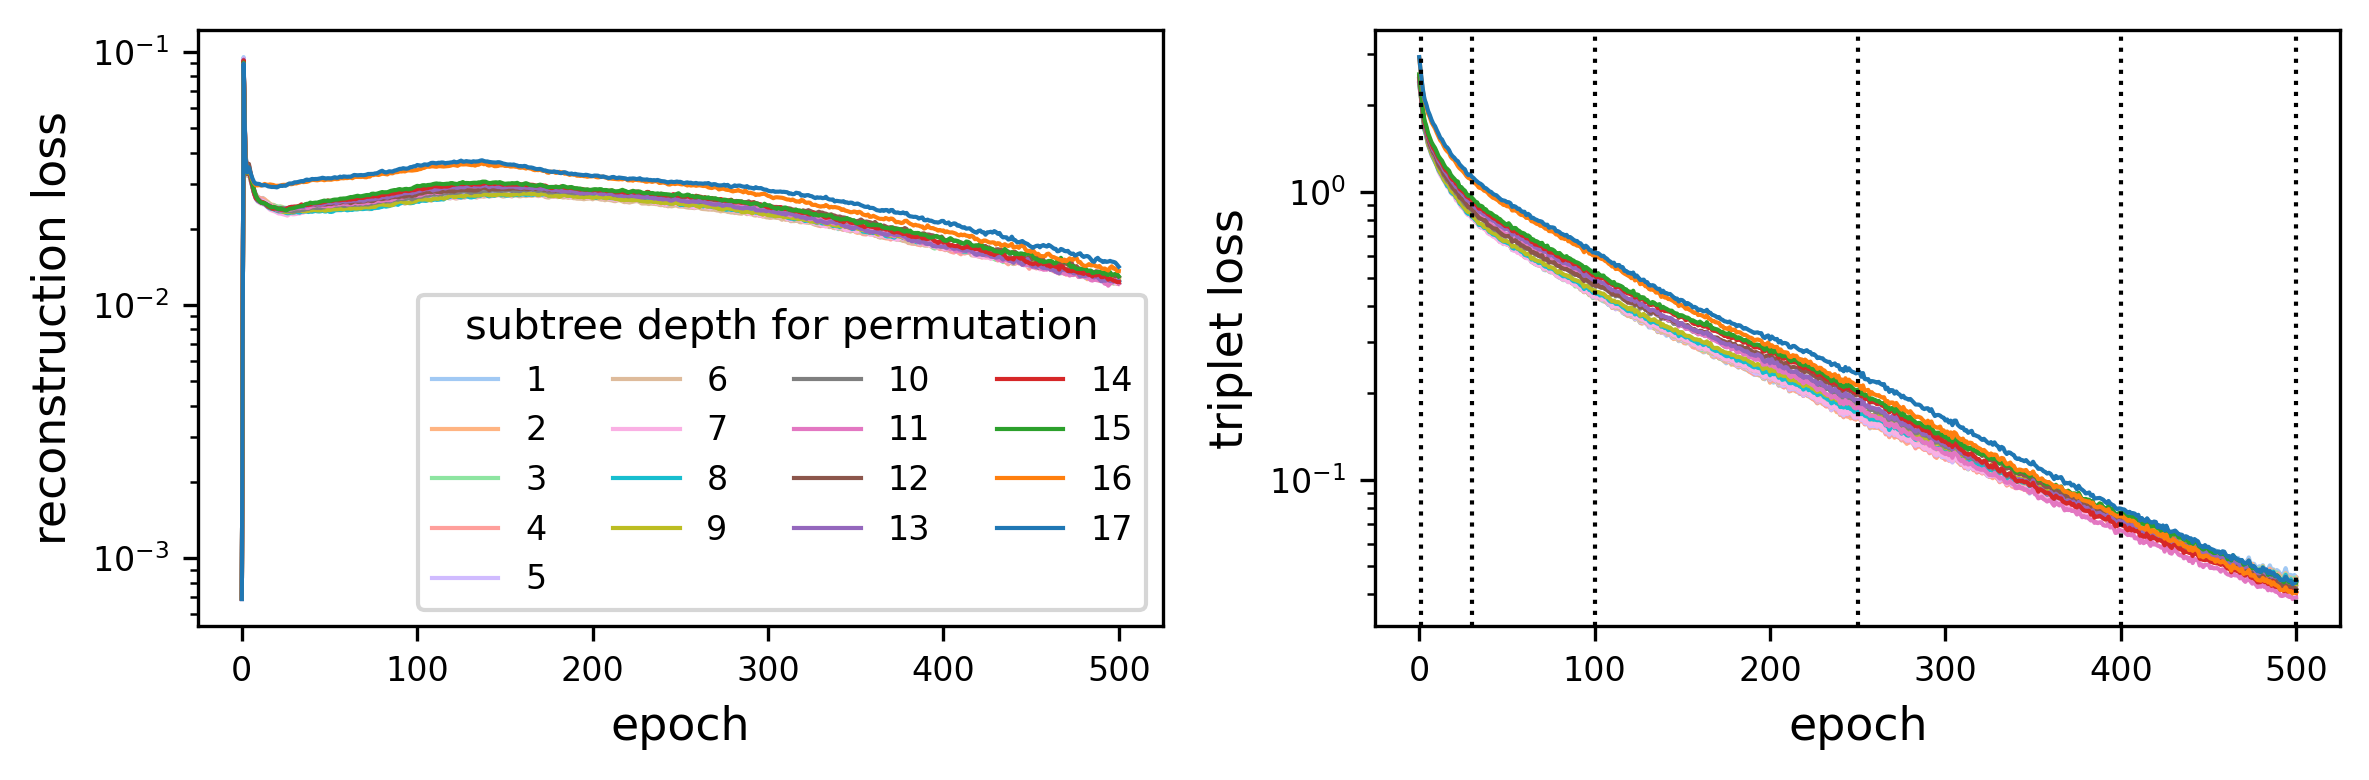

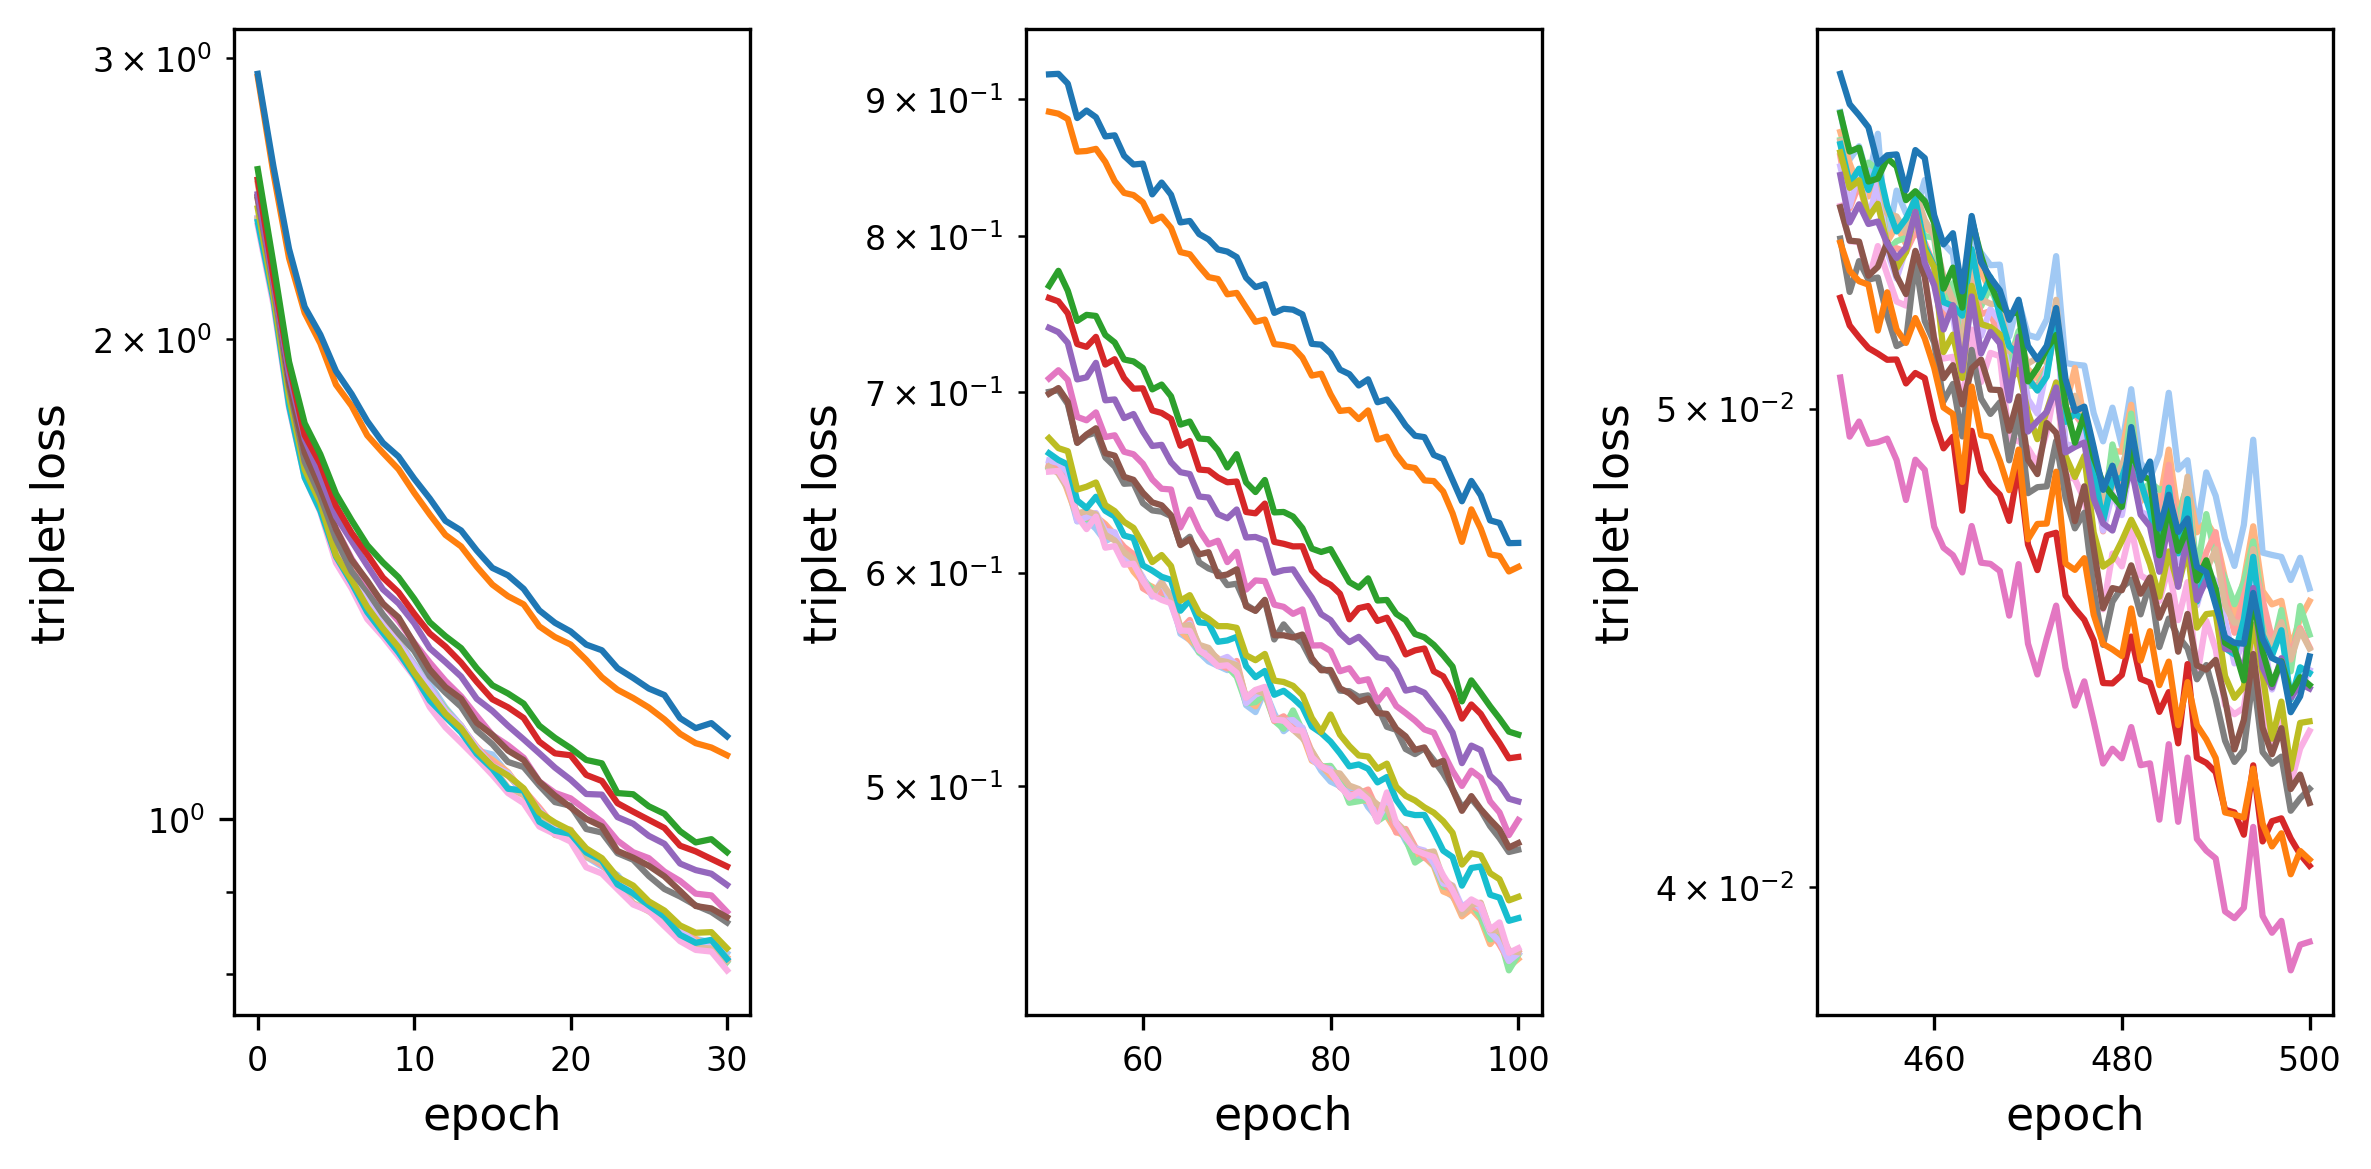

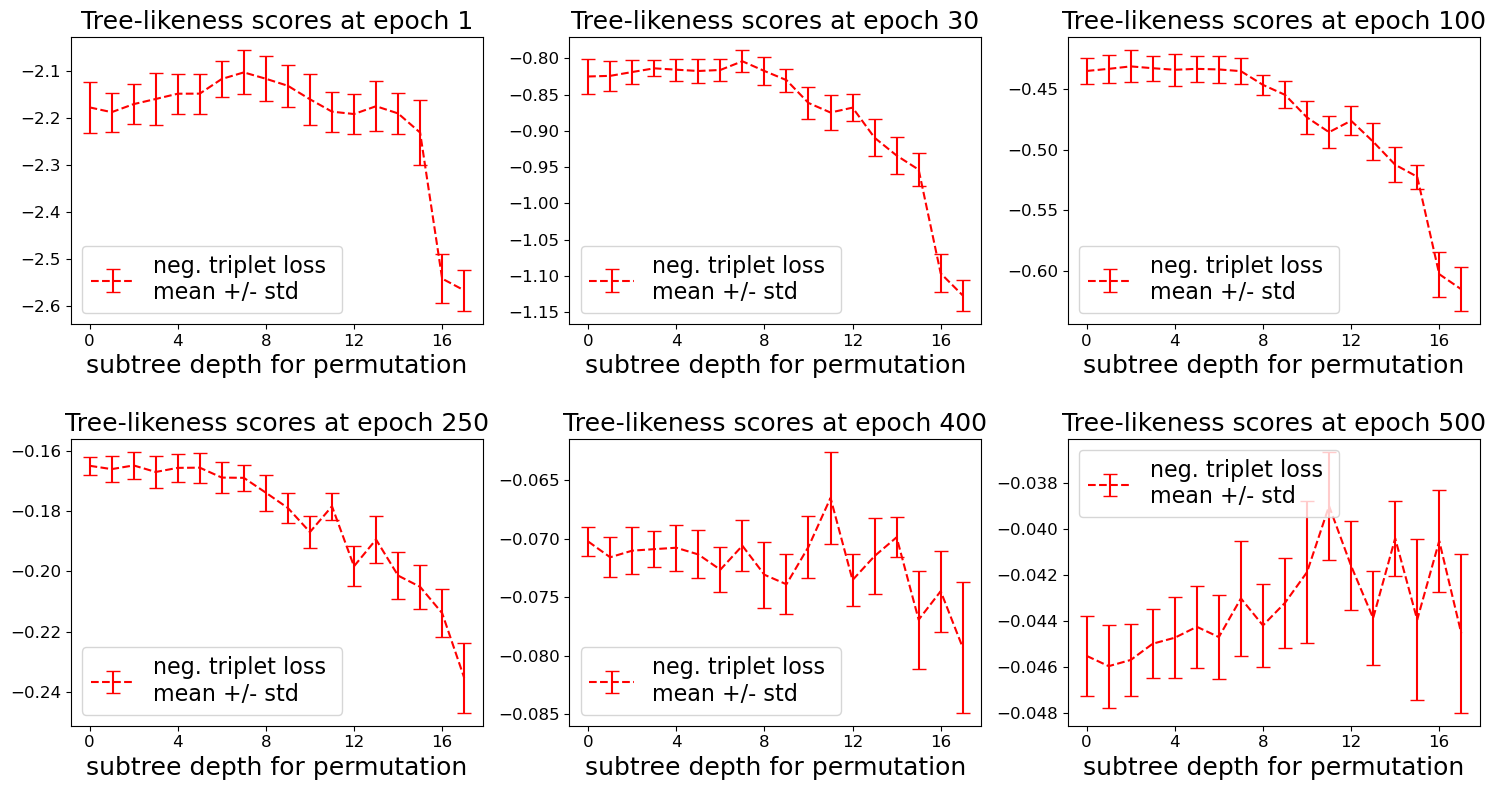

In [5]:
loss_perm_plots(name, 'AELR-2-1000', max_depth=17, stops=[1, 30, 100, 250, 400, 500], max_epoch=500, gene_subset_name='_hvg')

In [11]:
epoch = 250
# select only one type
has_type = (cell_types.loc[labels_in_order] == 'AT2-like').values.flatten()

depths = [0, 4, 15, 17]
feature_tsnes = []
for depth in depths:
  path = f'{results_path}/{name}_AELR-2-1000_lr1em4_e500_b128_h1_pd_pre_ts112221_perm12345d{depth:d}type_g100_hvg_e{epoch}.pt'

  subtrees = extract_subsets_with_depth(tree_path, depth=depth, include_labels=labels_in_order)
  label_subsets = []
  for stree in subtrees:
    label_subsets.extend(split_by_type(stree, cell_types))

  perm_ids = get_permutation_ids(labels_in_order, label_subsets, seed=12345)
  assert (cell_types.iloc[perm_ids].values == cell_types.values).all()

  np.random.seed(123121)
  feature_tsnes.append(get_tsne(get_features(
      torch.load(path, map_location=torch.device('cuda:0')), expression[hvg_genes].values[perm_ids], 'cuda:0')[has_type],
      perplexity=15))

np.random.seed(123121)
gene_tsne_type = get_tsne(expression[has_type], perplexity=15)
interactive_plot(node_data, edge_data, labels_in_order[has_type],
                 [top_down_clusters[has_type], cell_types.loc[labels_in_order].iloc[has_type]['type'].values.tolist()],
                 ['top down tree clusters', 'cell types'],
                 [gene_tsne_type] + feature_tsnes,
                 ['Preprocessed gene expression',  f'Learnt features permuting nothing'] + [
                    f'permuting subtrees of depth {depth}' for depth in depths[1:-1]
                 ] + ['permuting everything'], plots_per_row=3,
                 ).configure_legend(orient='bottom', direction='horizontal')

alt.VConcatChart(...)

## Tree-likeness score for cell types and permutation

In [26]:
# make data for tree likeness score by cell type plot
etree = Tree(tree_path, quoted_node_names=True, format=1)
aggs = {}
expected_lacs = {}
for t in main_types:
  subtree_labels = cell_types[cell_types['type'] == t].index.values if t != 'All' else None
  expected_lacs[t] = get_expected_lac_bmtm_depth_perm(etree, expression.index, labels_subset=subtree_labels)
  aggs[t] = get_perm_dists(expression, tree_path=tree_path, subtree_labels=subtree_labels, lut_path=lut_path)

with open(f'{results_path}/{name}_expected_lac.pk', 'wb') as handle:
  pickle.dump(expected_lacs, handle)
with open(f'{results_path}/{name}_real_lac.pk', 'wb') as handle:
  pickle.dump(aggs, handle)

torch.Size([55101475, 3])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:28<00:00,  1.66s/it]


torch.Size([8976776, 3])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:11<00:00,  1.45it/s]


torch.Size([1052208, 3])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.33it/s]


torch.Size([55773, 3])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:05<00:00,  3.09it/s]


torch.Size([14104, 3])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:03<00:00,  5.03it/s]


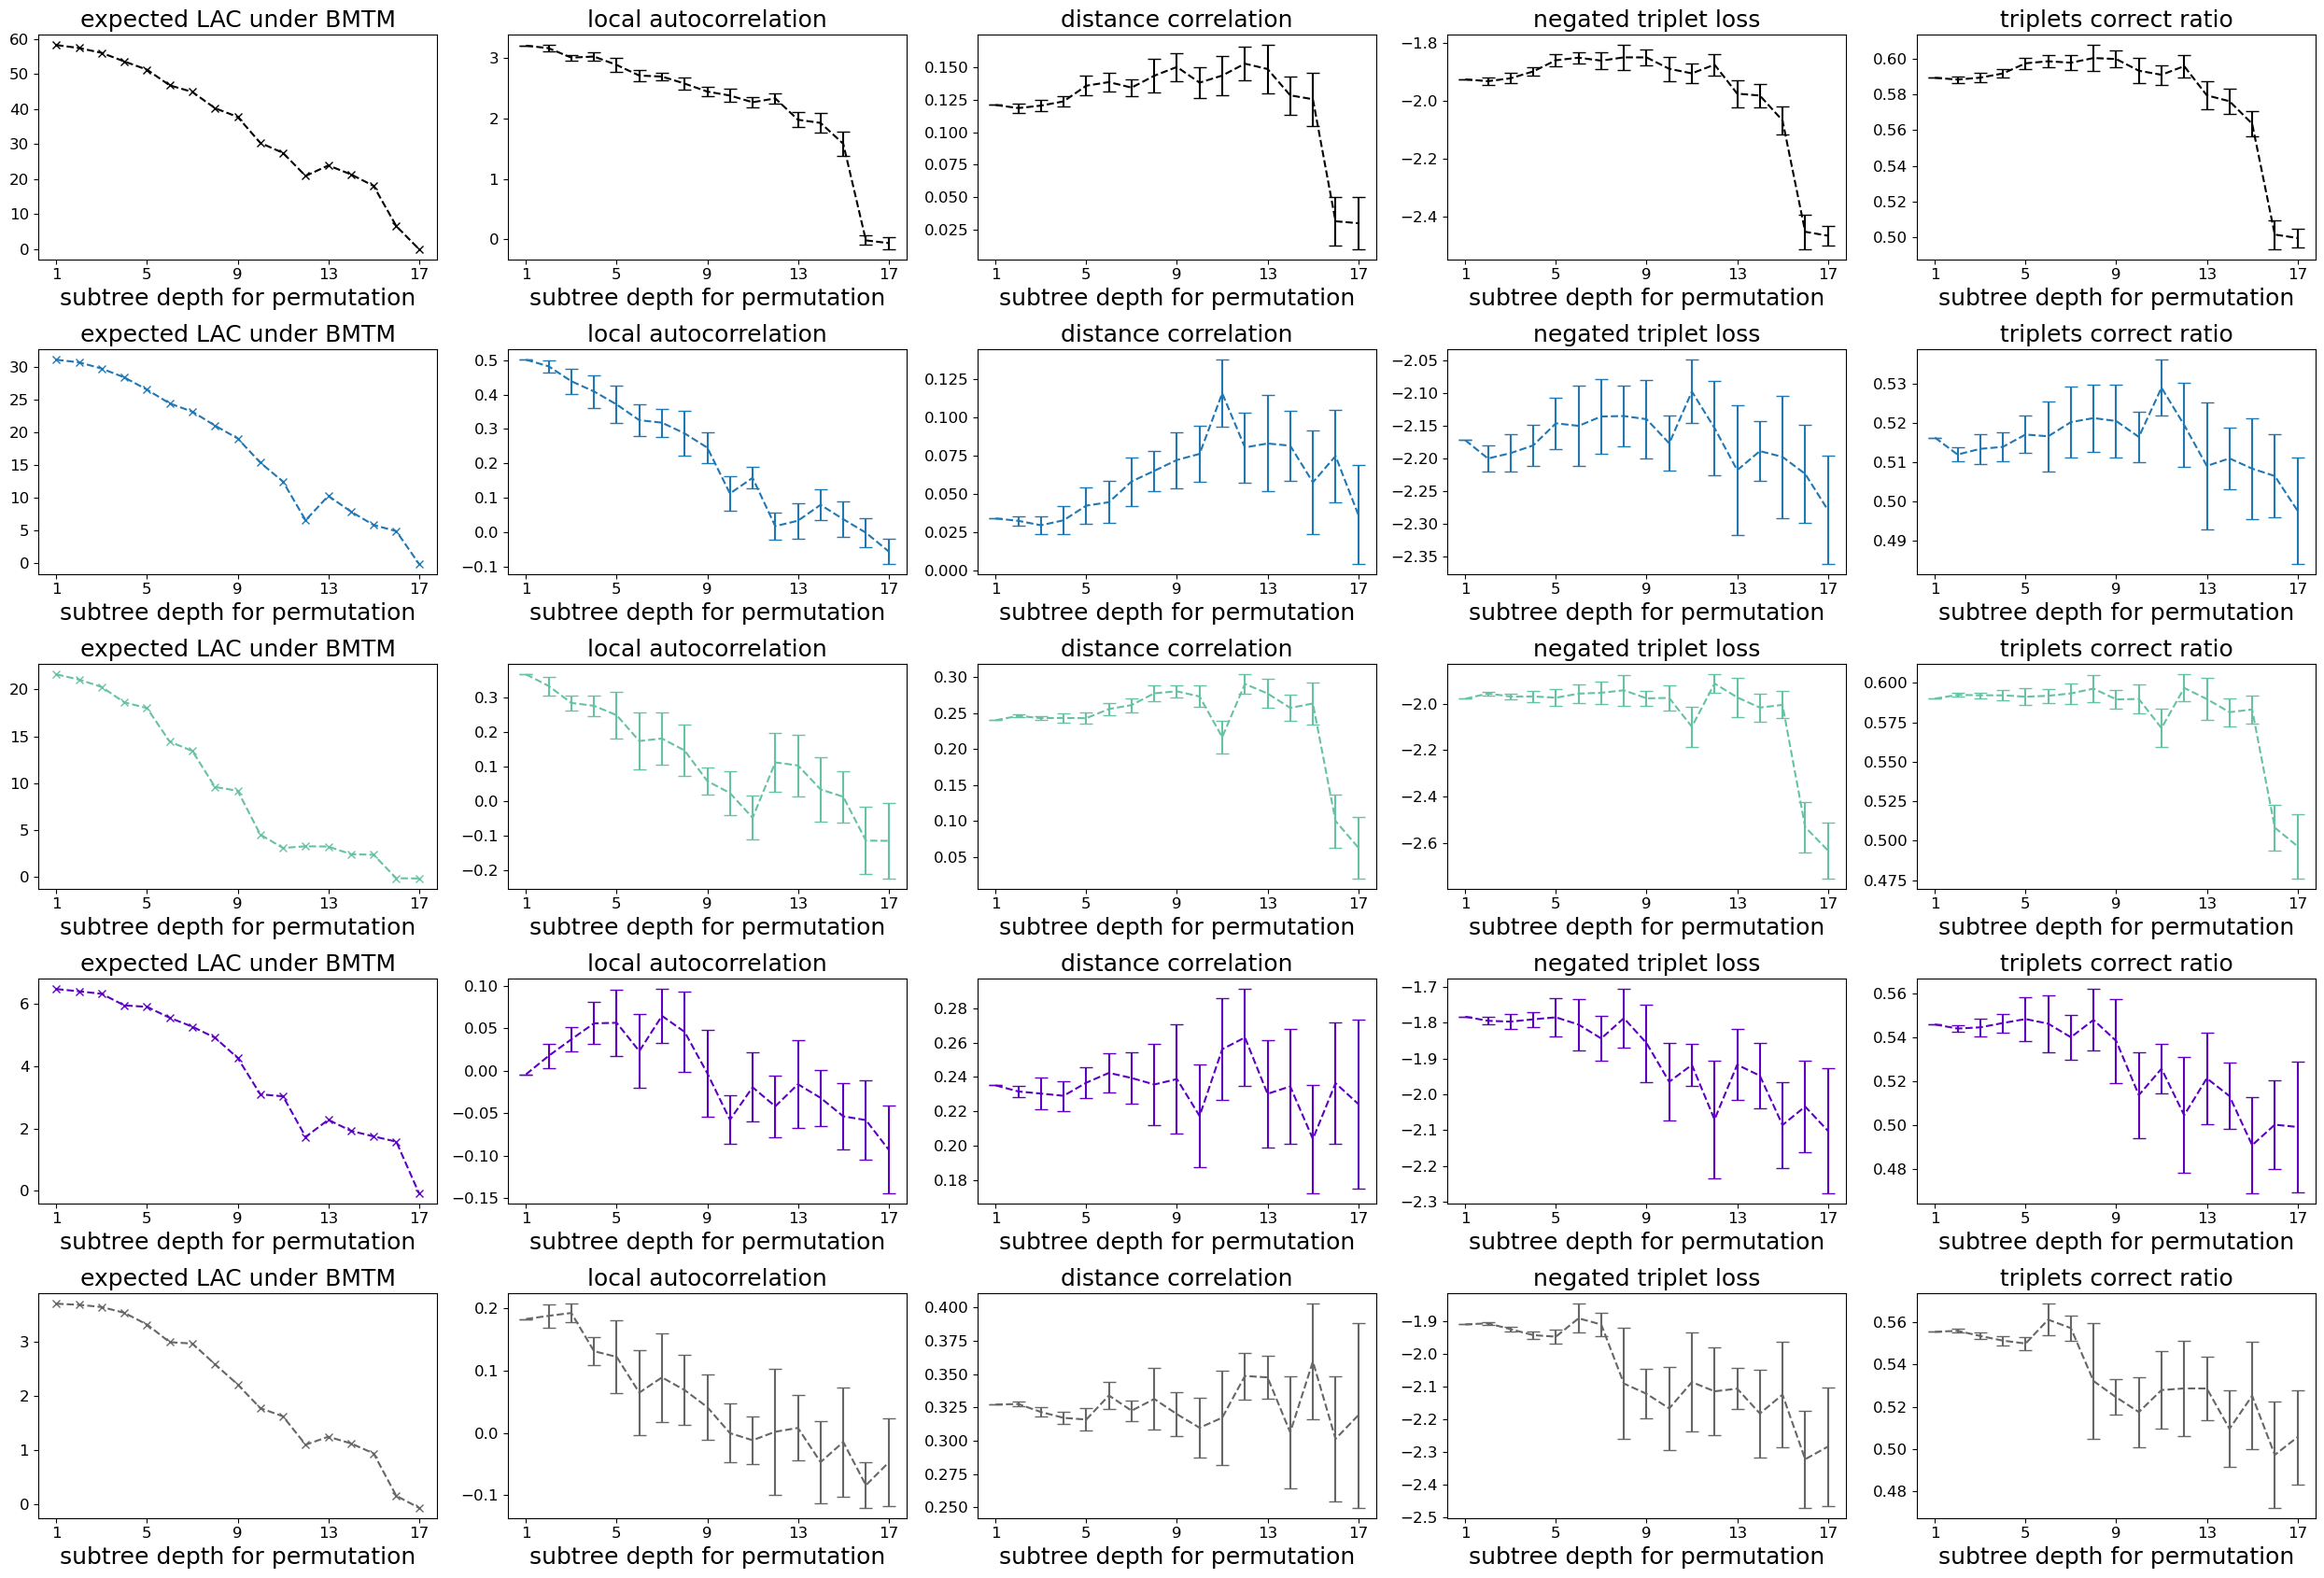

In [27]:
with open(f'{results_path}/{name}_expected_lac.pk', 'rb') as handle:
  expected_lacs = pickle.load(handle)
with open(f'{results_path}/{name}_real_lac.pk', 'rb') as handle:
  aggs = pickle.load(handle)

color_df.loc['All', 'color'] = '#000000'
dist_names = ['local autocorrelation', 'distance correlation', 'negated triplet loss', 'triplets correct ratio']
dist_ids = ['la', 'dc', 't', 'tc']
fig, axxs = plt.subplots(5, 5, figsize=(25, 17))
for i, t in enumerate(main_types):
  agg = aggs[t]
  expected_lac = expected_lacs[t]
  axs = axxs[i]
  for dist_name, dist_id, ax2 in zip(dist_names, dist_ids, axs.flatten()[1:]):
    ax2.errorbar(agg.index, agg[f'{dist_id}_expression_mean'], yerr=agg[f'{dist_id}_expression_std'],
                label=f'{t}', color=color_df.loc[t, 'color'], fmt='--', capsize=5)
    ax2.set_xlabel('subtree depth for permutation', fontsize=18)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    ax2.set_title(f'{dist_name}', fontsize=18)

    a = (agg[f'{dist_id}_expression_mean'] - agg[f'{dist_id}_expression_std']).min()
    b = (agg[f'{dist_id}_expression_mean'] + agg[f'{dist_id}_expression_std']).max()
    ax2.set_ylim(a - 0.05 * (b - a), b + 0.05 * (b - a))
    ax2.set_xticks(agg.index.values[::4].tolist())

  ax = axs[0]
  ax.plot(expected_lac['depth'], expected_lac['lac'], 'x--', color=color_df.loc[t, 'color'])
  ax.set_xlabel('subtree depth for permutation', fontsize=18)
  ax.tick_params(axis='both', which='major', labelsize=12)
  ax.set_title(f'expected LAC under BMTM', fontsize=18)
  ax.set_xticks(axs[1].get_xticks())
  n_cells = (cell_types['type'] == t).sum() if t != 'All' else len(cell_types)
fig.tight_layout()

# Figure S13

Uses helpers defined for Fig. S4

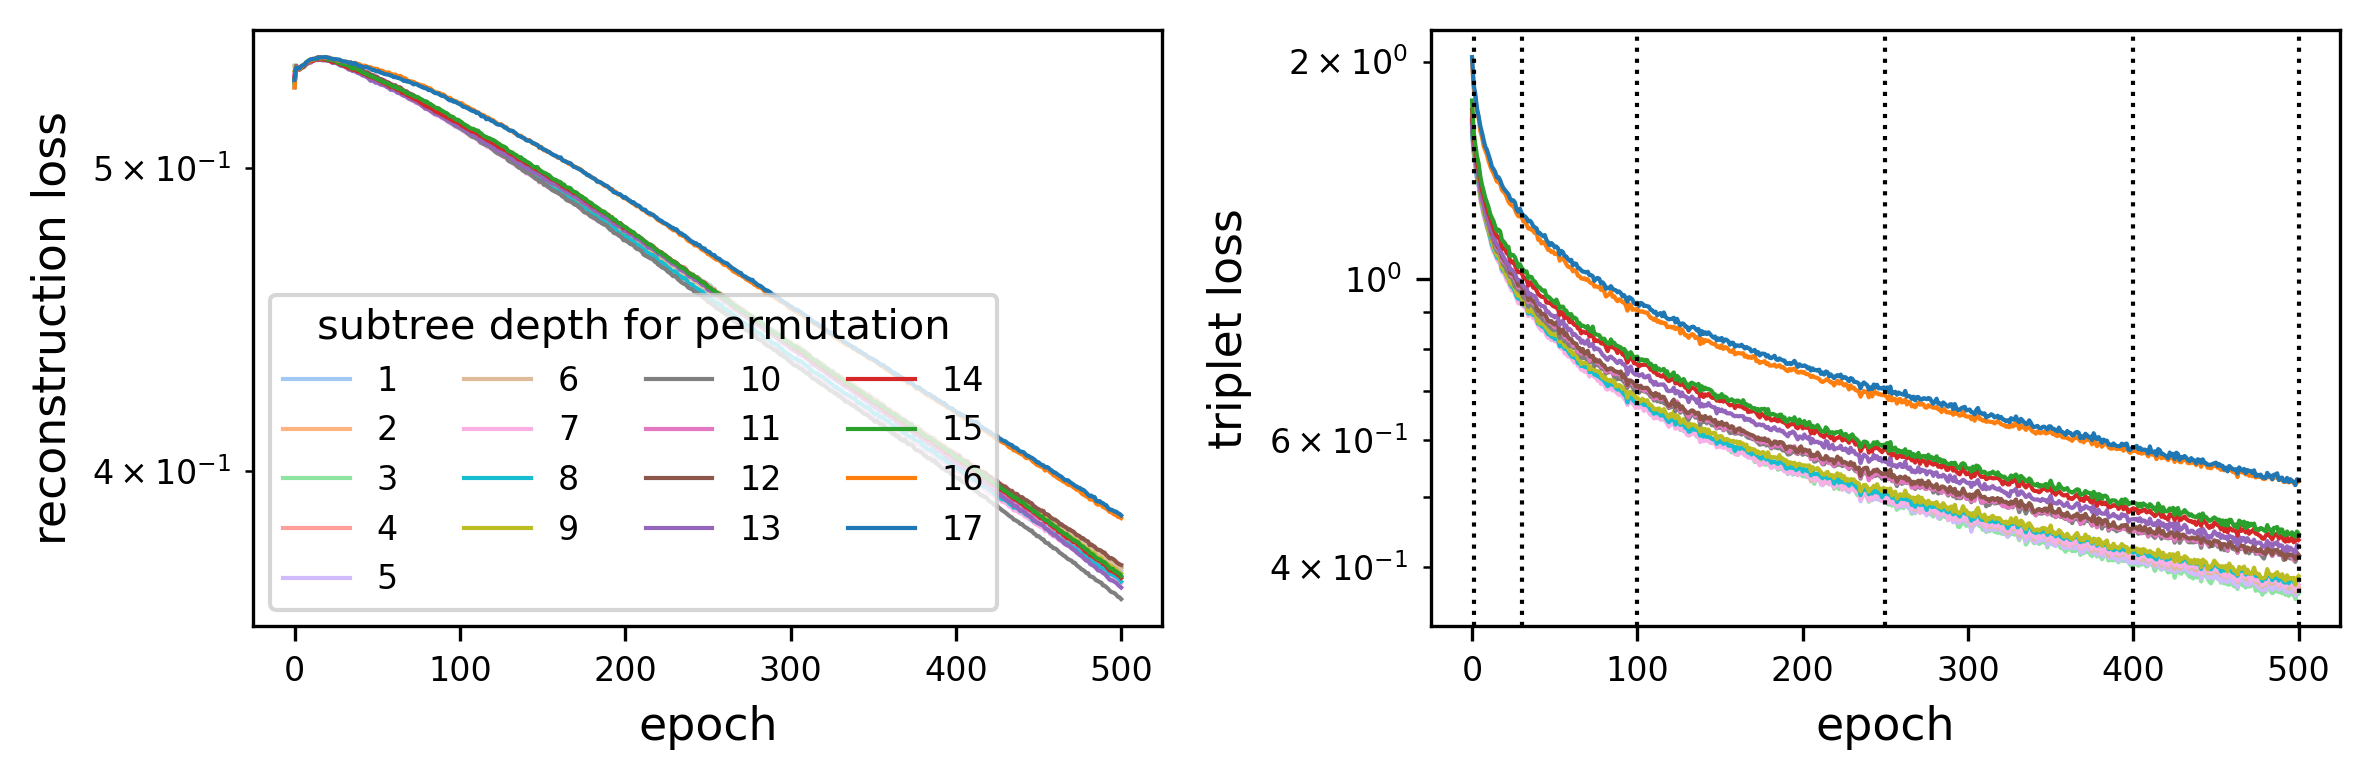

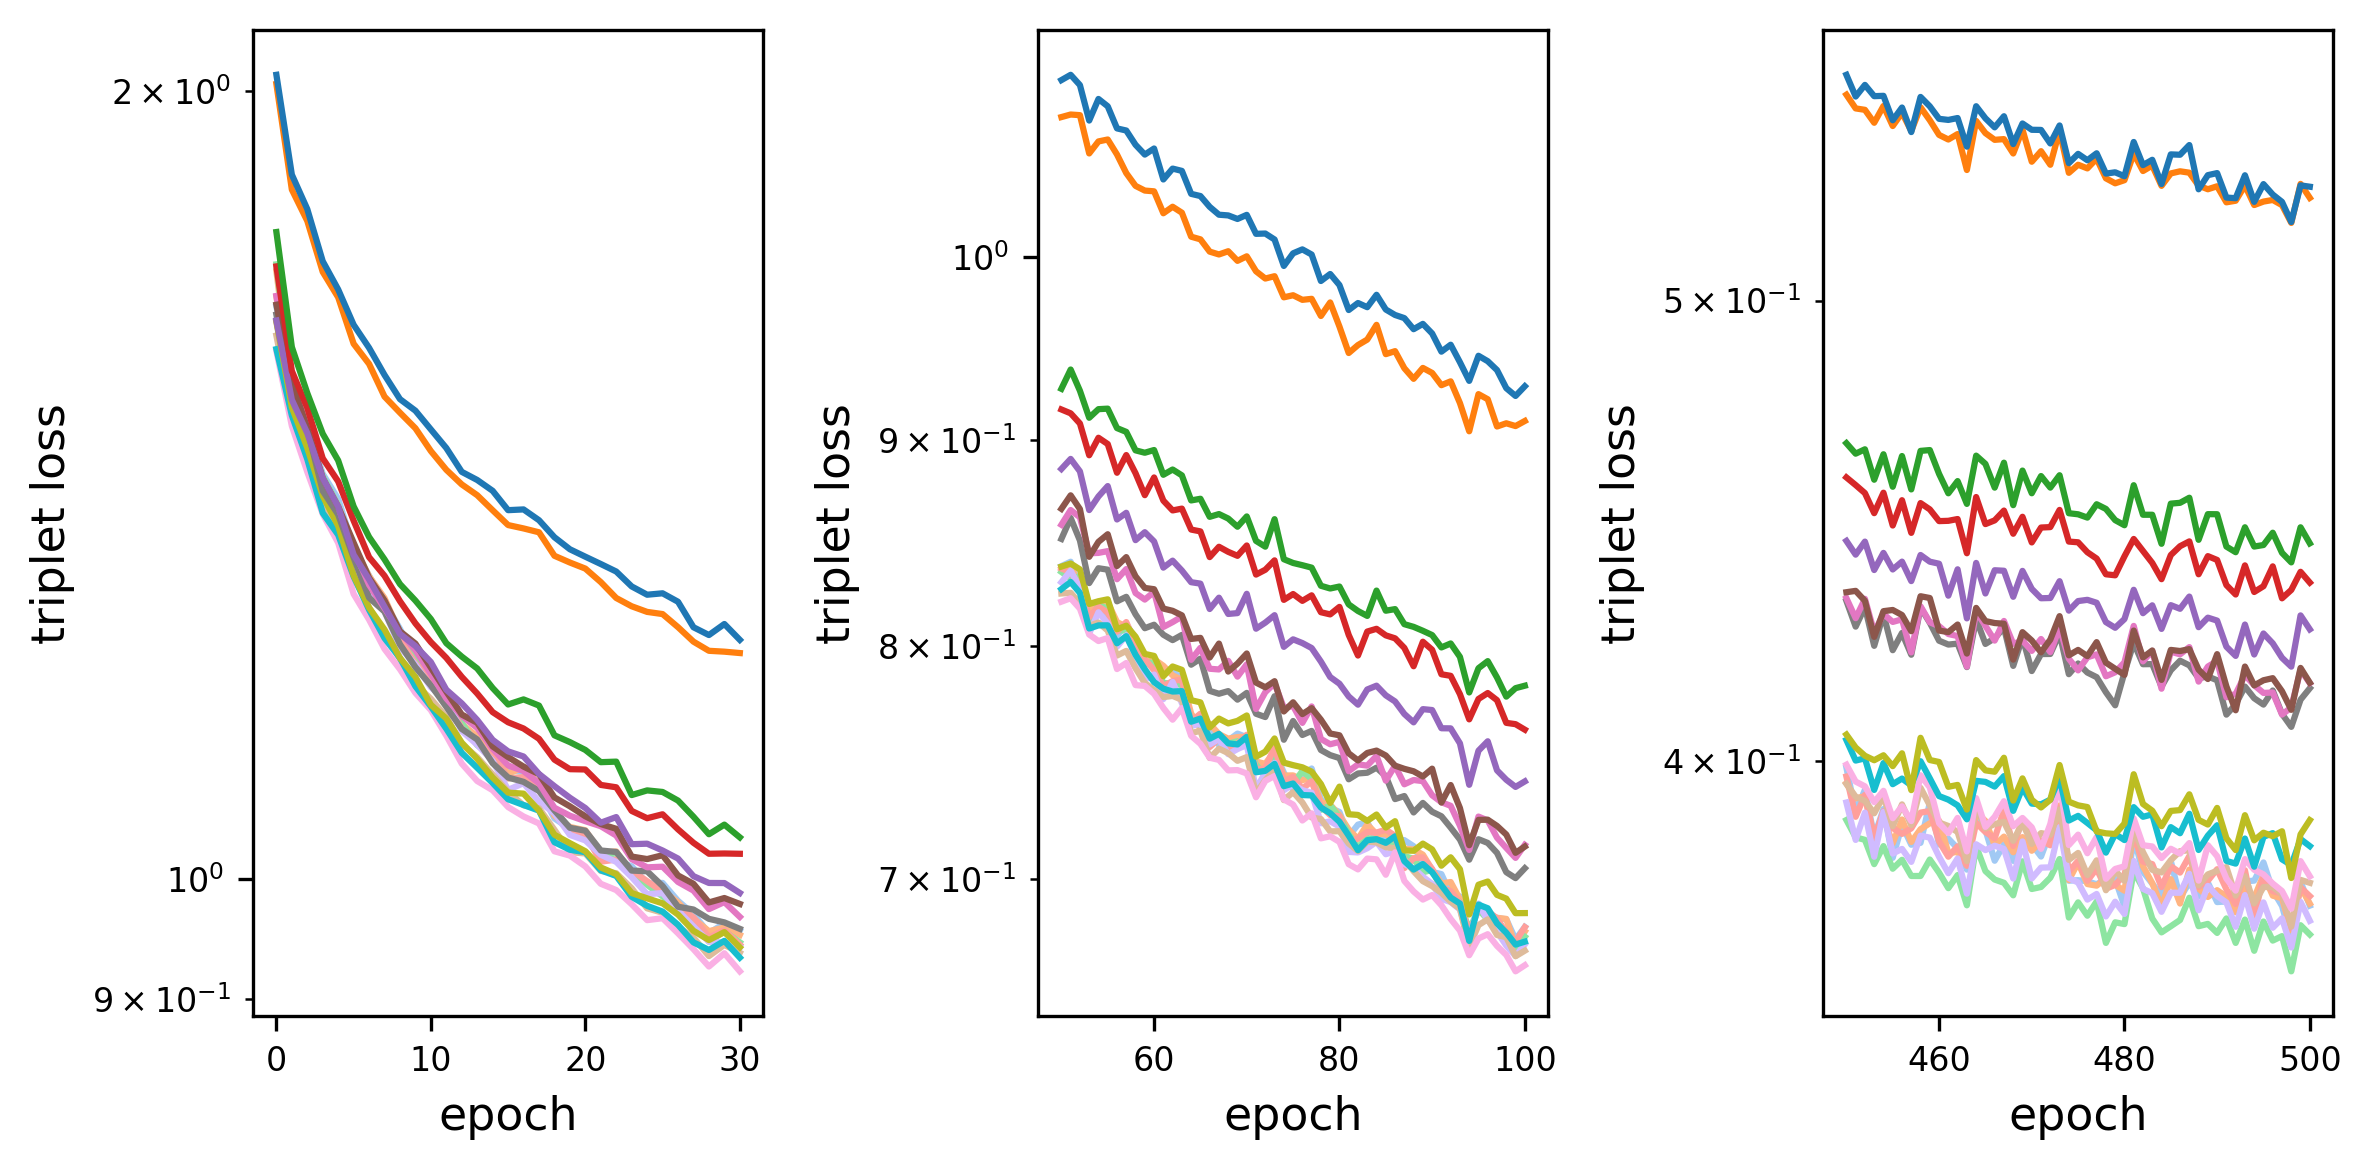

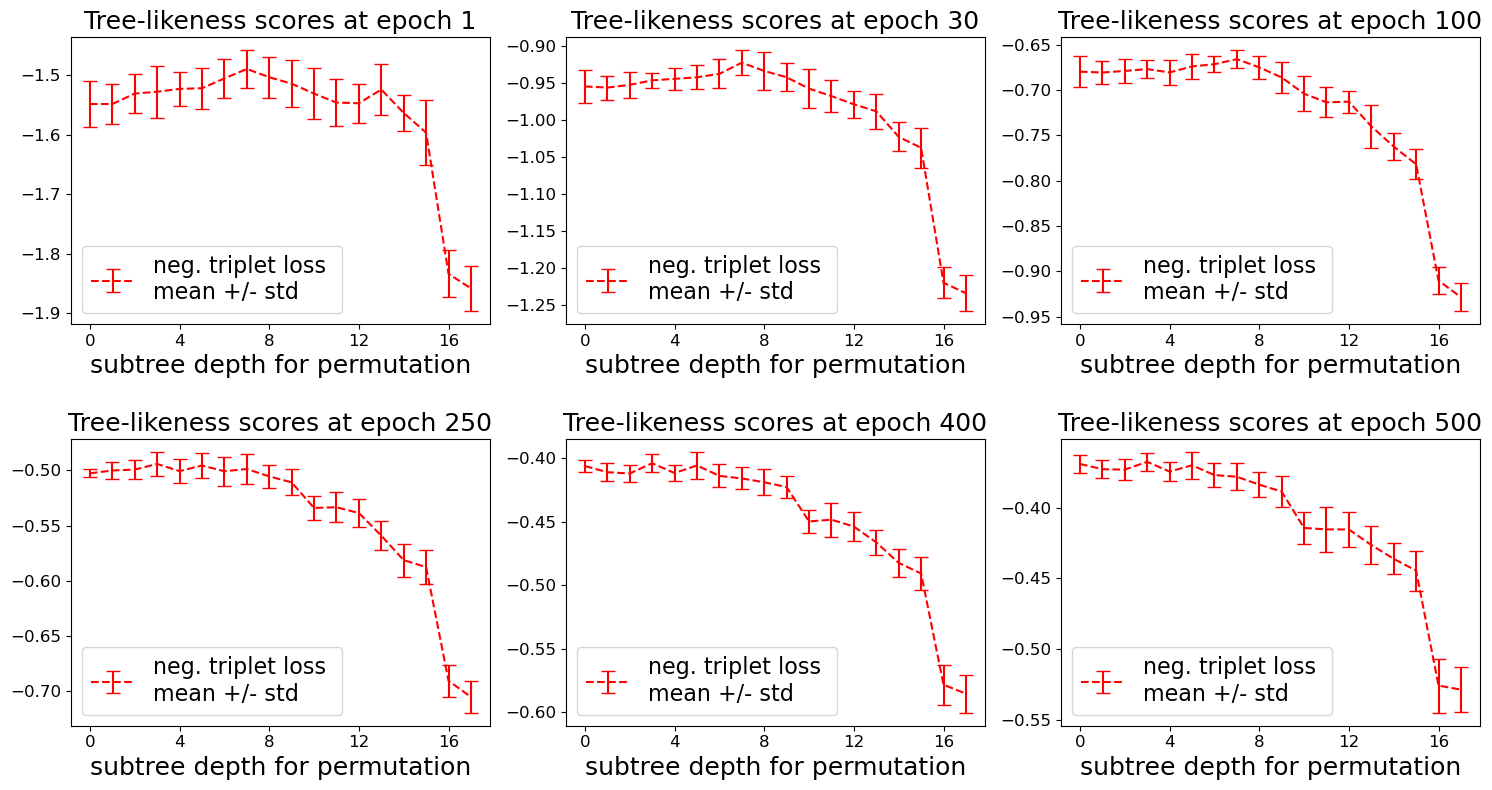

In [51]:
loss_perm_plots(name, 'AELR-2-100', max_depth=17, stops=[1, 30, 100, 250, 400, 500], max_epoch=500, gene_subset_name='_hvg')

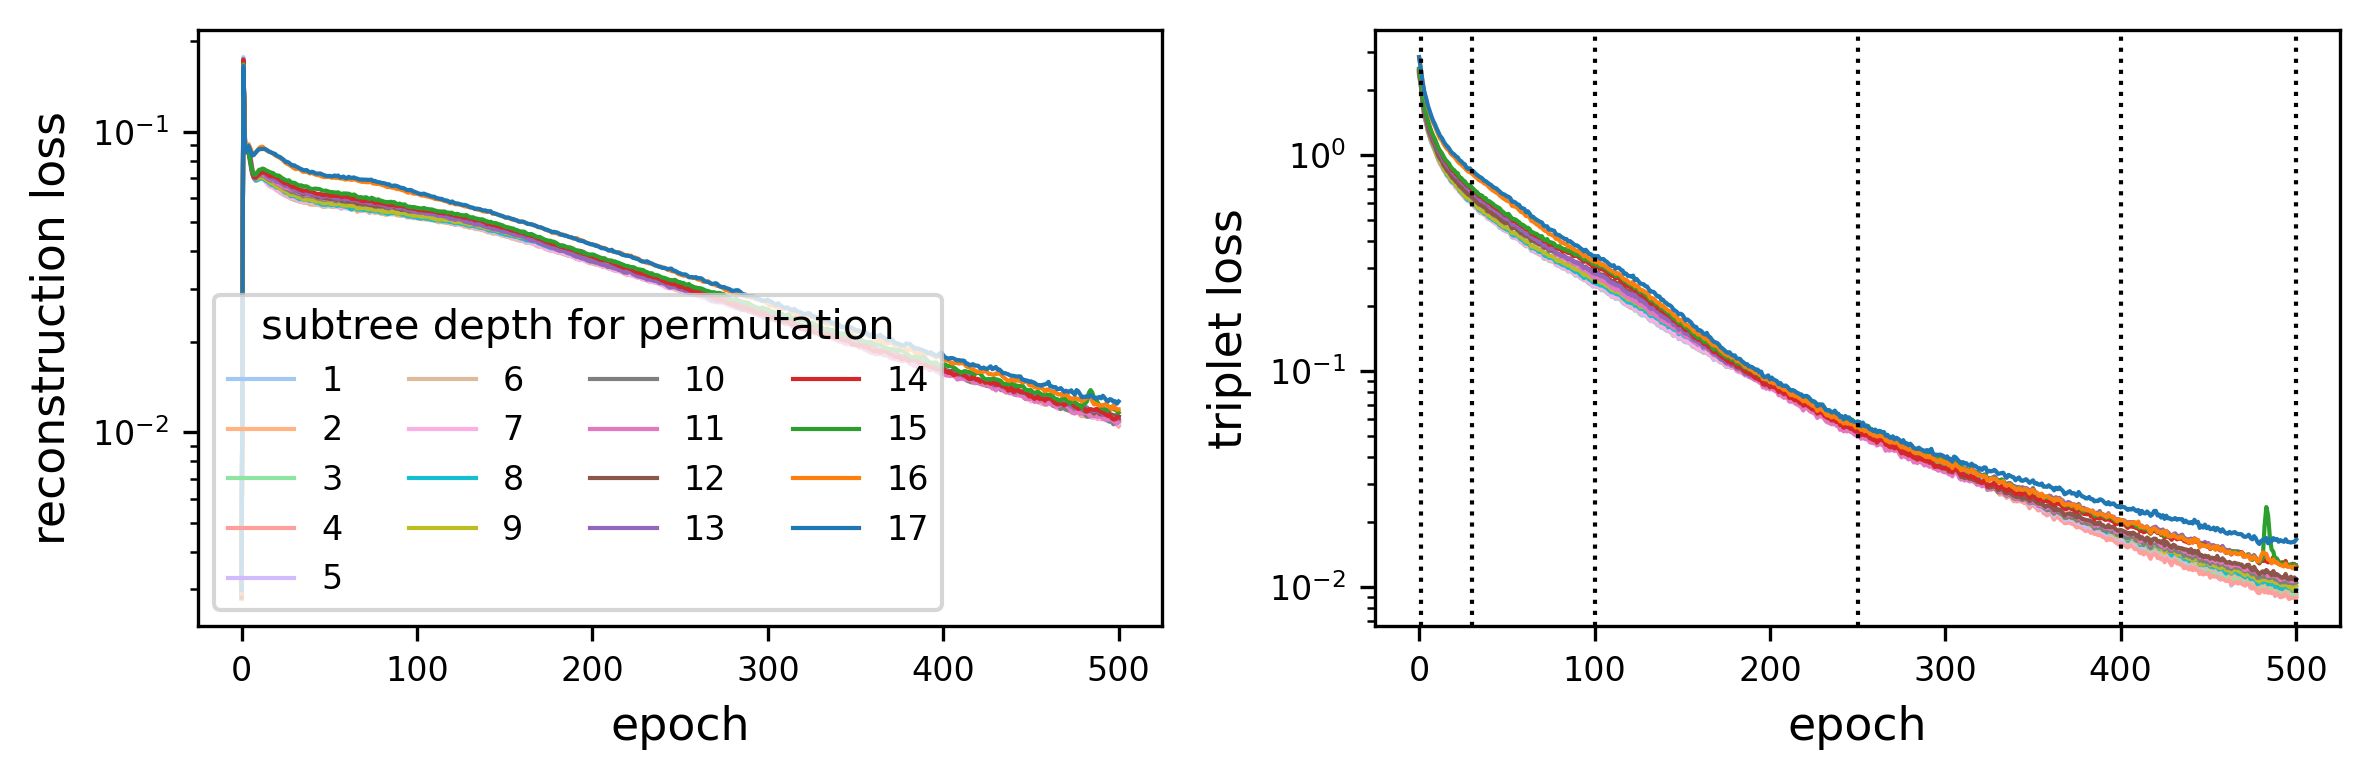

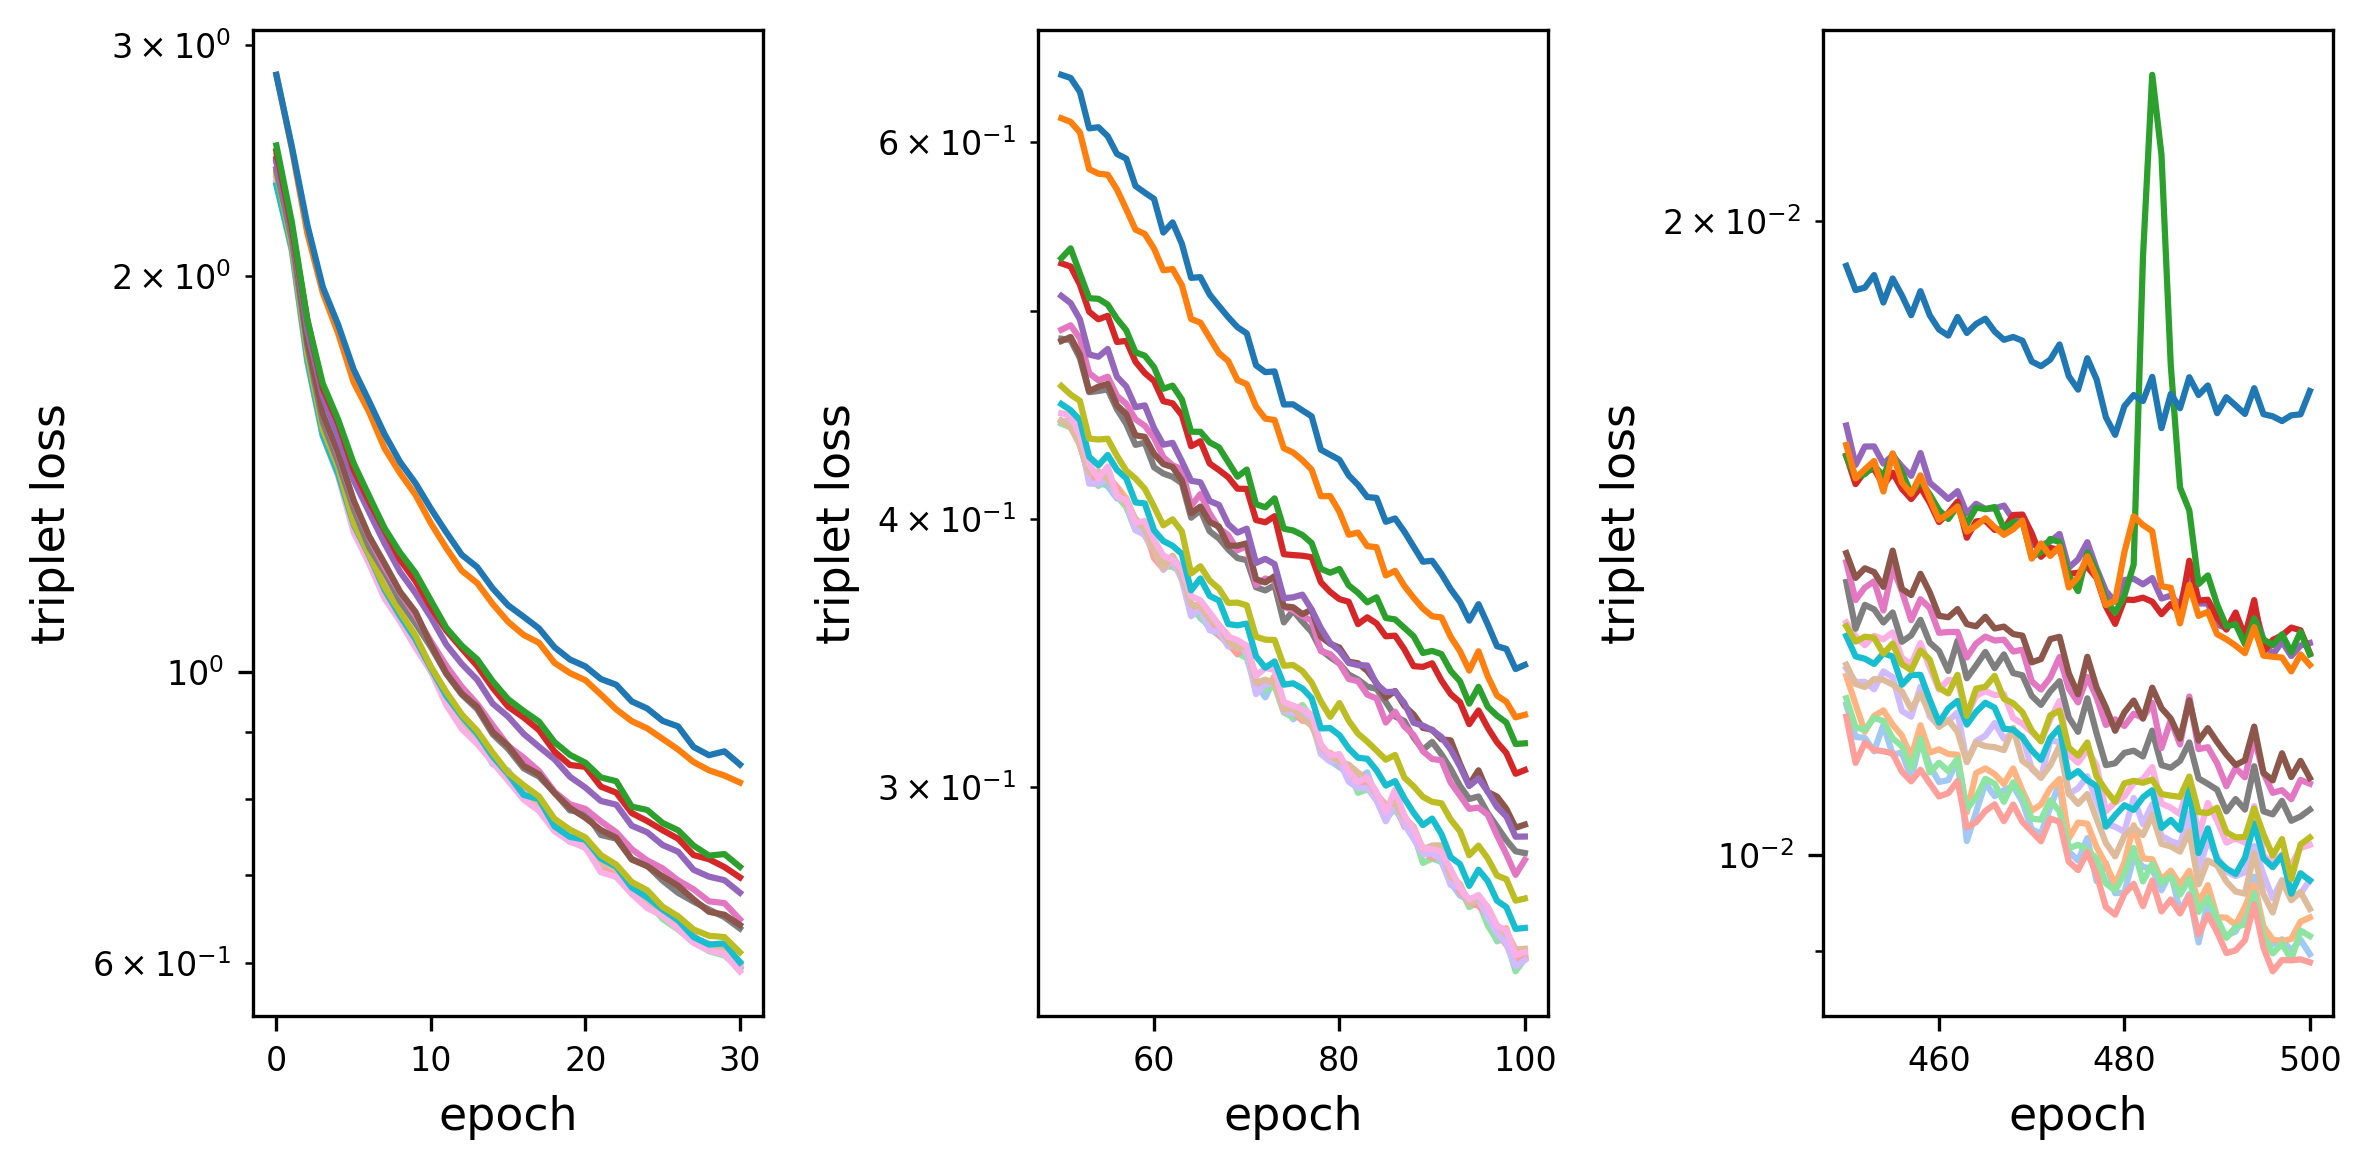

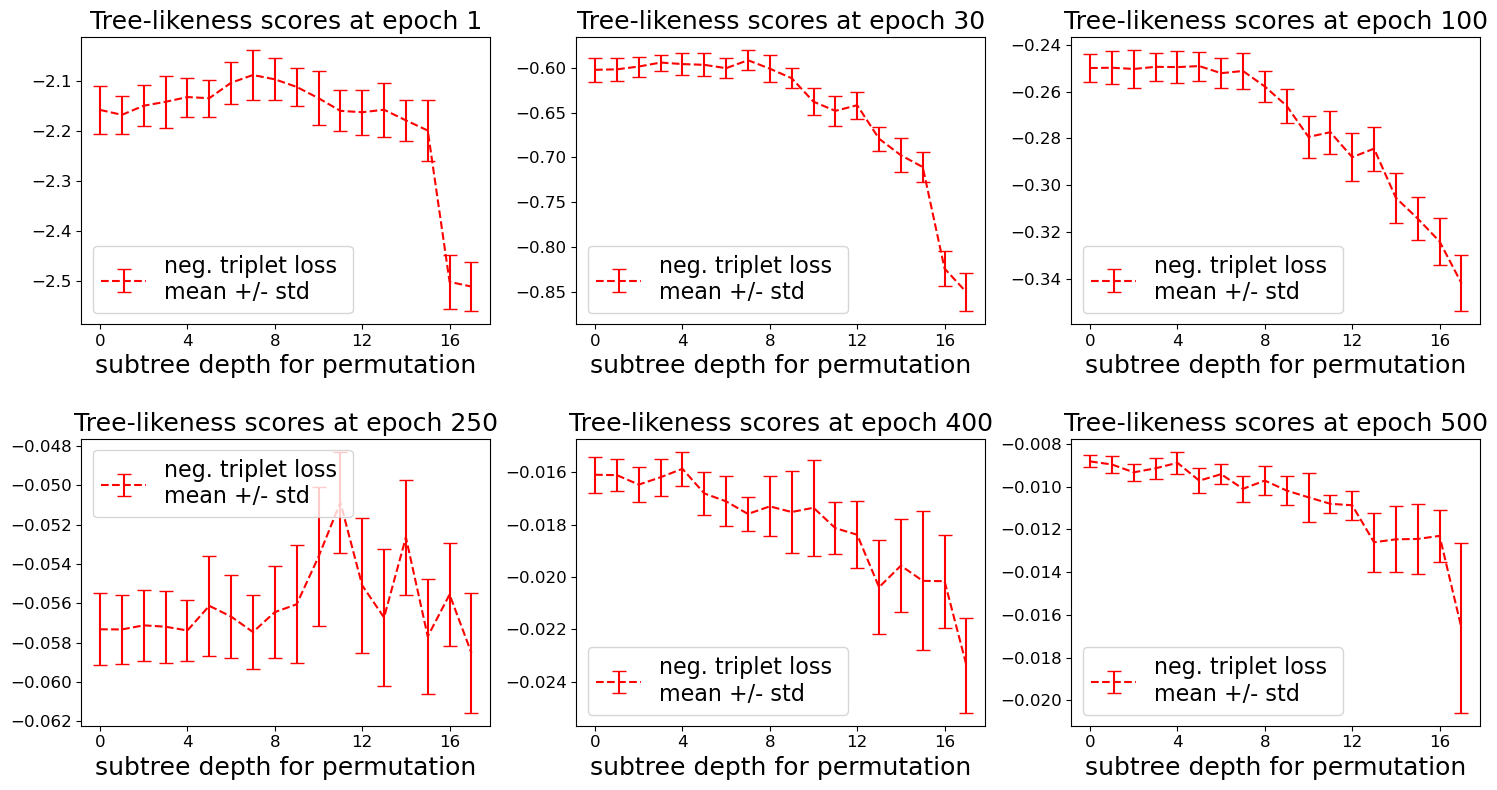

In [6]:
loss_perm_plots(name, 'AELR-3-1000', max_depth=17, stops=[1, 30, 100, 250, 400, 500], max_epoch=500, gene_subset_name='_hvg')